**MO-BOLFI**

The notebook is an implementation of Multi-objective BOLFI on MLBA with empirical dataset. We firstly construct the MLBA simulator (Hancock et. al., 2022),which can simulate choice-RT data for each observations. Next, we defined discrepancies of synthetic data from observed data for Chice and RT, repectively. Thirdly, a MOBOLFI model is built and approximate likelihood functions ara defined. Forthly, we draw DE-MCMC samples from the approxiamte posteriors, calculated by joint likelihood, marginal likelihood of response time data and marginal likelihood of choice data and compared it with closed-form MLBA estimate. Last but not least, we simulate choice-RT data based on diverse parameter set to demonstrate the weak dependence of discrepcies on part of parameters.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from scipy.optimize import minimize

Description of MLBA model is here.

*[Hancock et al, 2021](https://www.sciencedirect.com/science/article/abs/pii/S0191261521000576)*.

This experiment assesses the rental preferences of ride-hailing drivers in Singapore for electric vehicles (EVs) via a street-intercept survey [(Ding et al., 2024)](). Before the stated preference experiment, the driver’s basic information such as working days per week and information about currently rented internal
combustion engine vehicles (ICEVs) is collected. The drivers were asked to make a choice among three alternatives including ICEVs (Alt1 in dataset), Electric Vehicle Model A (EVA,Alt 3 in dataset), and Electric Vehicle Model B (EVB, Alt 4 in dataset) with three listed attributes, which are monthly rental cost (RC, in SGD), daily operating cost (OC, in SGD), and daily mileage (DR, in km). The time that
elapses from the appearance of information to the confirmation of choice is recorded as RT. Note that EVA and EVB are assumed to be identical except for their values of three listed attributes. After data preprocessing, 149 participants with 584 valid observations are used
in the parameter estimation. In
summary, the size of the attribute matrix X is 584*6, and the real output data for the MLBA simulator (RT,CH) is $584\times 4 $ , while each row has 1 response time record and 1 response choice record (3 dimensional one-hot encoding).

In [104]:
# Load choice-RT and attributes data
os.chdir('d:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/final code')
df = pd.read_csv("empirical_data.csv")
df.head(5)


Unnamed: 0                 ID Scenario  alt  chosen    RC  OC   DR    time  \
0           1  R_3fZBQYRcTj6rtUC   IND1.3    1       1  3000  45  550  35.820   
1           2  R_3fZBQYRcTj6rtUC   IND1.3    3       0  3900  14  350  35.820   
2           3  R_3fZBQYRcTj6rtUC   IND1.2    1       1  3000  45  550  22.010   
3           4  R_3fZBQYRcTj6rtUC   IND1.2    3       0  3600  14  350  22.010   
4           5  R_3fZBQYRcTj6rtUC   IND1.1    1       1  3000  45  550  47.948   

   Freq_p_week  nationality  Gender  marital   age  experience_months  income  \
0            7          4.0     2.0      1.0  68.0              300.0     1.5   
1            7          4.0     2.0      1.0  68.0              300.0     1.5   
2            7          4.0     2.0      1.0  68.0              300.0     1.5   
3            7          4.0     2.0      1.0  68.0              300.0     1.5   
4            7          4.0     2.0      1.0  68.0              300.0     1.5   

   education   
0         2.0  
1         2.0  
2         2.0  
3         2.0  
4         2.0

**Data Preprocessing**

We use all the A scenarios, including "A1.1","A1.1R","A1.2","A1.2R","A1.3","A1.3R","A1.4", and "A1.4R".  Each observation represents a candidate answered a question "Which one would you like to choose?" from 3 alternatives (denoted as 1, 3, 4 respectively in raw data), given 3 attributes values for each alternative. The final choice made and repsonse time of each candidate are recorded. The observtions with ID =\{"R_2xESOZsu1b0DK9W","R_1kUrkeP2G5SzhZ9,"R_3MLEPJF4WwO69ZI","R_28O4cGfWMqm0fkg","R_3lMIUHexfItTFyN","R_3HohVlDFTj1gqWK"\} is excluded due to the incomplete data or low response quality on "control question". After preprocession, there are 584 pbservations.


3 attributes:

RC - Renting cost (per month)

OC - Operating cost (per day)

DR - Driving range


The outcome from candidates are columns named "time" and "choice"."time" is the repsonse time during the scenario. The choice is the final chosen alternative of the candidate.

 Since monthly rental cost (RC) and daily operating cost (OC) capture the monetary aspect, these two can be merged into one alternative specific attribute
for the monthly total cost (TC, in SGD). $$TC_{na} = RC_{na} + OC_{na}\times WF_{n} \times 52/12,$$
where n and a are the indices of observation and alternative respectively. WFn is the number of working days per week, hence $TC_{na}$ is the monthly total cost for alternative a in observation n. Lastly, due to the heavy-tailed distribution of DR, it is transformed to log scale.

In [13]:
# define hyper params

number_of_alternatives = 3
number_of_attributes = 2
number_of_discrepancies = 2


In [105]:
# Add data scenarios one by one for convenient adding & deleting new data
df_data = df[df.Scenario == "A1.1"]
df_data = pd.concat([df_data, df[df.Scenario == "A1.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4R"]],axis=0)

#  remove observations with incomplete data or low-quality answer on control question
df_data.drop(df_data[(df_data.ID=="R_2xESOZsu1b0DK9W")|(df_data.ID=="R_1kUrkeP2G5SzhZ9")|(df_data.ID=="R_3MLEPJF4WwO69ZI")|(df_data.ID=="R_28O4cGfWMqm0fkg")|(df_data.ID=="R_3lMIUHexfItTFyN")|(df_data.ID=="R_3HohVlDFTj1gqWK")].index,inplace= True)


#  remove observations whose RT is outlier

rt_mean = np.mean(df_data.time)
rt_std =  np.std(df_data.time)
df_data.drop(df_data[(df_data.time<np.max([0,(rt_mean-3*rt_std)]))|(df_data.time>(rt_mean+3*rt_std))].index,inplace= True)



In [106]:
X_matrix = np.array(df_data[["RC","OC","DR","Freq_p_week"]].astype("float64"))



# Transform the columns RC and OC into TC  to unify the direction of optimization
# Given TC is an non-hedonic attribute, it contribution to the choice is negative. reverse it value in advance to let all attributes are positive contributed to the chosen probability.
X_matrix[:,0] = -X_matrix[:,0]-X_matrix[:,1]*X_matrix[:,3]*52/12
# let DR to take log
X_matrix[:,2] = np.log(X_matrix[:,2])
X_matrix[:,0] = (X_matrix[:,0]-X_matrix[:,0].min())/(X_matrix[:,0].max()-X_matrix[:,0].min())
X_matrix[:,2] = (X_matrix[:,2]-X_matrix[:,2].min())/(X_matrix[:,2].max()-X_matrix[:,2].min())

X_attributes = pd.DataFrame(np.take(X_matrix, [0,2], axis = 1))

X_attributes = pd.DataFrame(X_attributes.values.reshape(X_attributes.shape[0]//number_of_alternatives, number_of_attributes*number_of_alternatives),
                    columns=['TC1', 'DR1', 'TC3', 'DR3', 'TC4', 'DR4']) # set index by ID and reset_index for a new column




X_attributes



TC1       DR1       TC3       DR3       TC4       DR4
0    0.281256  0.759277  0.492271  0.386764  0.506763  0.154220
1    0.497295  1.000000  0.553816  0.633270  0.568309  0.479050
2    0.680580  0.759277  0.861449  0.386764  0.875942  0.154220
3    0.751884  0.958101  0.833527  0.633270  0.848019  0.479050
4    0.652367  1.000000  0.727729  0.633270  0.742222  0.479050
..        ...       ...       ...       ...       ...       ...
579  0.532077  0.865814  0.758164  0.479050  0.763961  0.280227
580  0.576329  0.814596  0.840097  0.479050  0.845894  0.280227
581  0.290048  0.865814  0.465894  0.479050  0.471691  0.280227
582  0.748406  0.759277  0.848696  0.386764  0.854493  0.154220
583  0.590145  0.699141  0.884058  0.386764  0.889855  0.154220

[584 rows x 6 columns]

In [16]:
# The response data

X_response = df_data[["ID","alt","chosen","time"]] # for online dataset


X_response[["time"]] = X_response[["time"]] # for online dataset

X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
X_response["chosen3"] = 1*(X_response['chosen']==1)*(X_response["alt"]==3)
X_response["chosen4"] = 1*(X_response['chosen']==1)*(X_response["alt"]==4)


X_response = X_response.drop(columns=["alt","chosen"])

condition_chosen = X_response[(X_response['chosen1']==0) & (X_response['chosen3']==0) & (X_response['chosen4']==0)].index
X_response = X_response.drop(condition_chosen)

C:\Users\e0729936\AppData\Local\Temp\ipykernel_20388\1588919508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response[["time"]] = X_response[["time"]] # for online dataset
C:\Users\e0729936\AppData\Local\Temp\ipykernel_20388\1588919508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
C:\Users\e0729936\AppData\Local\Temp\ipykernel_20388\1588919508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [17]:
X_attributes.shape

(584, 6)

**MLBA Simulator**

This section defines a simulator model that generates outcomes (fixation_trail, choice) given a set of parameter values and attributes data. The model refers to *[Hancock et al, 2021](https://www.sciencedirect.com/science/article/abs/pii/S0191261521000576)*.


For Citation: Hancock, Thomas O., et al. "An accumulation of preference: two alternative dynamic models for understanding transport choices." Transportation Research Part B: Methodological 149 (2021): 250-282.

In [18]:
def create_distance_matrix(row, number_of_alternatives,number_of_attributes):
    rows = row.values.reshape(number_of_alternatives,-1)
    distance_matrix = np.zeros((number_of_alternatives,number_of_alternatives,number_of_attributes))
    for i in range(number_of_alternatives):
      for j in range(number_of_alternatives):
        distance_matrix[i,j,:] = rows[i,:]-rows[j,:]

    return distance_matrix

# Test using first row (obs) of the data
create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

array([[[ 0.        ,  0.        ],
        [-0.21101449,  0.37251326],
        [-0.22550725,  0.60505719]],

       [[ 0.21101449, -0.37251326],
        [ 0.        ,  0.        ],
        [-0.01449275,  0.23254394]],

       [[ 0.22550725, -0.60505719],
        [ 0.01449275, -0.23254394],
        [ 0.        ,  0.        ]]])

In [19]:
def compute_mean_drift_rate(X_attributes,lambdas,log_I0,betas,deltas):
    """
    This function is only used in mlba() to compute mean values of drift rate normal distribution
    X_attributes: standardized data of attributes of alternatives
    dis_ij_k = attributes_i - attributes_j for alternative i and j, attribute k for each individual n
    betas: a vector with dimension of number of attributes, attribute specific constants
    deltas: a 2-dim vector with dimension of number of alternatives, alternative specific constants, delta_last is set to be 0
    trans_lambdas: a 2-dim vector, lambda = lambdas[0] if dis_ij is positive, otherwise = lambdas[1]
    log_I0: log of a positive constant that makes the probability of all negative drift rates small
    w_n_ij_k = exp(-lambda*betas_k*|dis_ij_k|)
    V_ij = sum(w_ijk*dis_ijk) for k = 1 to number of attributes
    d_i = max(0,(delta_j + sum(V_ij) + I)) for j = 1 to number of alternatives
    """
    number_of_candidates = int(X_attributes.shape[0])
    means = np.zeros((X_attributes.shape[0], number_of_alternatives))
    lambda0, lambda1 = lambdas[0], lambdas[1]
  
    for n in range(number_of_candidates):
        attributes_n = X_attributes.iloc[n,:] # attributes of individual n
        distance_matrix = create_distance_matrix(attributes_n, number_of_alternatives, number_of_attributes)
        Lambda = np.where(distance_matrix>0,lambda0,lambda1)
        Beta = np.repeat(np.repeat(np.array(betas).reshape(1,-1),number_of_alternatives,axis=0),number_of_alternatives,axis=0).reshape(-1,number_of_alternatives,number_of_attributes)
        weight_temp = -1*np.multiply(Lambda,np.multiply(Beta,np.absolute(distance_matrix)))
       
        
        # weights_matrix = np.exp(-1*np.multiply(Lambda,np.multiply(Beta,np.absolute(distance_matrix))))
        weights_matrix = np.exp(weight_temp)
        V_n = np.multiply(weights_matrix,np.multiply(Beta,distance_matrix))
        V_n = np.sum(np.sum(V_n,axis=2),axis=1)
        delta1 = np.zeros((1,1))
        Delta = np.concatenate((np.array(deltas).reshape(1,-1),delta1),axis=1) # set the last alternative as reference
        V_n = V_n + Delta + np.exp(log_I0)

    
        # the mean drift rate is non-negative
        means[n,:] = np.where(V_n>0, V_n, 0) # the mean drift rate is non-negative

    return means

In [20]:
import scipy.stats

def MLBA(X_attributes, lambdas,log_I0,  betas, deltas, threshold, A = 48, s=1 ):
    """
    MLBA simulator
    input: parameters that are derectly used in MLBA model & data X
    output: choice outcome and response time
    Details:
    A:starting point upper bound such that start points of accumulators will follow this Unif(0,A).
    threshold: threshold is the boundary which reaches the first accumulator(final choice), here actually is log(threshold-A) 
    X_response: Choice made and coresponding response time of candidates
    s: common sd of N(u_n, s), the drift rate of the ith accumulator d_n~N(u_n, s)
    u_n: mean values u_n, computed from compute_mean_drift_rate() for individual n

    """

    number_of_candidates = int(X_attributes.shape[0])
    
    # reparameterize the threshold and beta
    threshold = np.exp(threshold)+A
    betas = np.exp(betas)


   

    # Initialize the accumulators and the starting point
    accumulators = np.zeros((number_of_candidates,number_of_alternatives))
    start_points = np.random.uniform(low=0, high=A, size=(number_of_candidates,number_of_alternatives))
    accumulators = accumulators + start_points

    # Compute the mean of normals that drift rate follows for each accumulator
    means = compute_mean_drift_rate(X_attributes, lambdas, log_I0, betas, deltas)
    drift_rates = means
    # print(means)
    for i in range(number_of_candidates):
        for j in range(number_of_alternatives):
            drift_rates[i,j] = scipy.stats.truncnorm.rvs(a = (0- means[i,j])/s, b = (400- means[i,j])/s , loc= means[i,j], scale=s).item() 
            # here to only draw non-negative drift rate so that no need for the non-negative drift rate check in the following

    # here to only include non-native sampler

    # For each candidate, run the mlba simulation game
    rt = np.zeros(number_of_candidates)
    choice = np.zeros((number_of_candidates,number_of_alternatives))
    for n in range(number_of_candidates):
        accumulators_n = accumulators[n,:]
        drift_rates_n = drift_rates[n,:]
        
        rt_candidate = (threshold-start_points[n,:])/drift_rates_n
        choice_n = np.argmin(rt_candidate)
        choice[n,choice_n] = 1
        rt[n] = rt_candidate[choice_n]

    return (rt,choice)

In [21]:
#Test
MLBA(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(10),
                        betas=[1,0.5],deltas=[-10,-0.3], threshold=5)

(array([15.7926278 , 16.03267519, 16.48353879, 18.34881234, 16.57115745,
        17.09257407, 17.56877282, 14.40964663, 16.43251677, 15.13547114,
        19.33738933, 15.80253193, 16.5345285 , 18.78333666, 19.38639194,
        14.85681588, 15.50313012, 14.82907205, 16.50508853, 15.03007998,
        17.65616374, 16.27285059, 16.87150371, 15.11334454, 16.51547819,
        15.73274307, 14.82698549, 18.76583366, 15.9325366 , 17.46306782,
        19.43727783, 19.11990577, 16.9701107 , 15.38661307, 14.11030142,
        17.38823724, 17.79826509, 15.87488608, 15.72187973, 16.28497742,
        14.49211248, 16.799154  , 18.54199607, 17.95296091, 18.58641176,
        13.70534327, 16.20048084, 19.67751017, 15.75528208, 16.90214215,
        16.5567711 , 15.16798208, 22.30229788, 14.73723294, 15.51886484,
        19.14595736, 16.45057091, 18.5577226 , 16.97098012, 13.33196289,
        15.11872068, 14.45023949, 17.21685149, 15.99359783, 15.95208304,
        15.81833403, 21.14063537, 14.20684719, 17.0

**discrepancies**

Define discrepancies between some summary statistics on simulated and observed data. Currently the raw rt & choice data is viewed as summary statistics on itself. S = 30 synthetic data is used for discrepancy calculation. $\Delta_1^*$ is the average of 1-Wasserstain distance of sorted $log(RT)$ between sythetic data and observed data.  $\Delta_2^*$ is the Brier Score based on observed choice and empirical choice proportion based on S replicates. The detailed formulas can be seen in the manuscript. 

Note: $\Delta_1^*$ and $\Delta_2^*$ are scaled with some scalar to ensures the effciency of BO algorithm.

In [22]:
def minus_simluated_discrepancy(theta, X_response=X_response, X_attributes=X_attributes):
    """
    X_response: Observed choice and coresponding response time of candidates
    X_attributes: standardized data of attributes of alternatives, used for compute mean value of normals that drift rates follow
    Each row of X is an individual-specific alternvative's attributes
    theta: a vector of all parameters, orderly including (lambdas, log_I0, betas, deltas, log_(threshold-A))
    output: distance between simulated choice & resposne time and observed choice & response time
    We take log of I0 and threshold because they are positive numbers, taking log maps them to the whole real line, which is approporaite for prior definition and MCMC
    """
    
   
   # Observed data
    X_response_rt = X_response[["time"]].values
    X_response_choice = X_response[["chosen1","chosen3","chosen4"]].values

    lambdas, log_I0, betas, deltas, threshold = theta
    X_response_rt = X_response_rt.reshape(-1)
    nObs = len(X_response)

    # Simulation discrepancy (take log of rt discrepancy)
    
    iter_n = 30
    discrepancies = np.zeros((1,number_of_discrepancies)) # 2 discrepancies
    discrepancy_rt_candidate = [-1]*iter_n
    choice_candidate = np.zeros(X_response_choice.shape)

    for i in range(iter_n):
        (rt_sim,choice_sim) = MLBA(X_attributes, lambdas, log_I0, betas, deltas, threshold)

        rt_dis = np.abs(np.log(np.sort(X_response_rt))-np.log(np.sort(rt_sim)))/3 
       
        discrepancy_rt_candidate[i] = np.mean(rt_dis)
        choice_candidate +=choice_sim

    discrepancy_rt = np.mean(discrepancy_rt_candidate)
    choice_candidate = choice_candidate/iter_n
    discrepancy_choice =(np.sum((choice_candidate-X_response_choice)*(choice_candidate-X_response_choice))/nObs -0.6)*3 
    discrepancies[0,:] = (discrepancy_rt, discrepancy_choice)
    


    return discrepancies*-1


If you want to try other design of the discrepancies, you can define the above function by yourself. The commented discrepancy function uses only single simulation (i.e. S = 1) to let 1-Wasserstain distance of sorted log $RT$ as $\Delta_1$, and the mean absolute value of choice to be $\Delta_2$. The estimation results are displayed in the supplementary.



In [ ]:
# def minus_simluated_discrepancy(theta, X_response=X_response, X_attributes=X_attributes):
#     """
#     X_response: Observed choice and coresponding response time of candidates, default to be the real data we collect
#     X_attributes: standardized data of attributes of alternatives, used for compute mean value of normals that drift rates follow
#     Each row of X is an individual-specific alternvative's attributes
#     theta: a vector of all parameters, orderly including (lambdas, log_I0, betas, deltas, log_(threshold-A))
#     output: distance between simulated choice & resposne time and observed choice & response time, called ch/rt discrepancy below
#     We take log of I0 and threshold because they are positive numbers, taking log maps them to the whole real line, which is approporaite for prior definition and MCMC
#     The CH discrepancy is 1-Wasserstien distance between simulation data and real data, the RT discrepancy is L1 distance between log of order statistics of simualtion data and that of real data
#     Given the complexity of the MLBA, there is no means to find its exact closed form sufficient statistic, the choice of disccrepancy here comes from the convention in decision-making model literature for evaluating model prediction
#     """

#     # Observed data
#     X_response_rt = X_response[["fixation_trail"]].values
#     X_response_choice = X_response[["chosen1","chosen3","chosen4"]].values

#     lambdas, log_I0, betas, deltas, log_threshold_A = theta
#     X_response_rt = X_response_rt.reshape(-1)


#     # Simulation discrepancy (take log of rt discrepancy to control the maginitude of rt discrepancy)
#     discrepancies = np.zeros((1,number_of_discrepancies)) # 2 discrepancies
#     (rt_sim,choice_sim) = MLBA(X_attributes, lambdas, log_I0, betas, deltas, log_threshold_A)
#     rt_dis = np.abs(np.log(np.sort(X_response_rt))-np.log(np.sort(rt_sim)))
#     # print(np.std(rt_dis))
#     discrepancy_rt = np.mean(rt_dis)/1
#     discrepancy_choice = np.abs(choice_sim-X_response_choice).mean(axis=1).mean(axis=0)
    
#     # Scale the components of discrepancy and put all components on a similar scale, the scaling weight is calculated from algorithm 1 in paper supplmentary, rounded to 1 decimal places
#     # The scaling weight would change depending on the finite samples, if the simulator is expensive we should not be able to use too many samples to get the scaling weight
#     # Here we use sample size 100 in algorithm 1, putting discreapncy components on a similar scale but not approximately the same
#     discrepancy_choice *= 0.7
#     discrepancies[0,:] = (discrepancy_rt, discrepancy_choice)
    
#     # To match the assumption of botorch package, which we use later, that the objective is default to be maximized, here we defines the output as the negative of discrepancies
#     # In discussion below we'll no longer remind this, to avoid abuse of language in description of key content.
#     return discrepancies*-1

MO-BOLFI is a likelihood-free inference method that effectively surrogates simulators like MLBA model. In real-world data example, we don't know the true value of parameter. The motivation of this exeperiment is to compare the approximate llk by MOBOLFI with closed-form posterior. Therefore, in the rest of this notebook, the "real_theta" here is the MAP of closed-form llk parameter estimation. 



In [23]:
# real_theta here is the MLBA closed-form  MAP 
                    
real_theta = [0.2120024, 0, 0, 0.5799932 , 0, np.log(7.8672462),np.log(3.0079402) ,  np.log(2.0819559)]
real_theta

[0.2120024,
 0,
 0,
 0.5799932,
 0,
 2.0627080901415162,
 1.1012555255708283,
 0.7333077884122489]

In [24]:
real_data = MLBA(X_attributes,lambdas=real_theta[0:2], log_I0=real_theta[2],
                    betas=real_theta[3+number_of_alternatives-1:3+number_of_attributes+number_of_alternatives-1],
                    deltas=real_theta[3:3+number_of_alternatives-1],
                    threshold=real_theta[-1])

real_response = pd.DataFrame(real_data[1], columns=["chosen1", "chosen3", "chosen4"])
real_response = pd.concat([pd.DataFrame(real_data[0], columns = ["time"]), real_response],axis=1)

In [27]:
real_response.describe() # closed-form
X_response.describe() #observded 

time     chosen1     chosen3     chosen4
count  584.000000  584.000000  584.000000  584.000000
mean    11.468971    0.410959    0.450342    0.138699
std     11.384608    0.492430    0.497955    0.345928
min      1.021000    0.000000    0.000000    0.000000
25%      4.238250    0.000000    0.000000    0.000000
50%      7.764500    0.000000    0.000000    0.000000
75%     14.319750    1.000000    1.000000    0.000000
max     68.911000    1.000000    1.000000    1.000000

In [ ]:
real_response = X_response # let real data is equal to observed data

In [1963]:
# Test discrepancy func with real_theta (MAP of closed-form llk)
minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]],[real_theta[3],real_theta[4]],real_theta[7]), X_response=real_response)

array([[-5.64561288e+02, -1.98731507e-01]])

In [27]:
# std (time) = 11.384608
real_data_var = 11.384608**2

real_data_var

129.609299313664

**Multi-objective BO-LFI based on multi-variate GP model**

In [28]:
import scipy.stats
import matplotlib
seed = 1234
np.random.seed(seed)

The initual value selection here is adaptive to ensure the discrepancies distribution of initial data and paramter values distributed to domain as uniform as possible.

In [29]:
# Firstly, we need to build data for training, i.e. pairs of {theta_i, delta_i}, i=1,...,N
num_of_parameters = 2+number_of_attributes+number_of_alternatives-2 # one more constraint on alt3& alt4 initial value 

num_init_samples = 50

# Set the mean and variance of normal prior
# Set weakly informative prior, i.e. larger variance and prior mean away from true param values
# However, do not set values out of the bounds of parameter space
# Prior mean should not be too large, otherwise the resulted rt would be too large

def init_sample_generator(num_init_samples = num_init_samples):
    
    init_sample_theta = np.zeros((num_init_samples, num_of_parameters))
    init_sample_discrepancy = np.zeros((num_init_samples, number_of_discrepancies))

    i = 0
    mean_drift_invalid_check = False
    smallvaluesignal = True
    while i < num_init_samples:
        print(i)
        # Sample initial theta from the prior
       

        init_lambda0 = np.random.uniform(low=-0.001, high=5, size=1).item()
        init_beta1 = np.random.uniform(low=-3, high=5, size=1).item()
        init_beta2 = np.random.uniform(low=-3, high=5, size=1).item()
        init_delta1 = np.random.uniform(low=-3, high=10, size=1).item()
        init_threshold = np.random.uniform(low=-2, high=6, size=1).item()
       

        init_theta = np.concatenate(([init_lambda0],[real_theta[1]], [real_theta[2]], [init_delta1],[real_theta[4]],
                                     [init_beta1],[init_beta2],[init_threshold]),axis=0).tolist()

        # The follow three judgement will help us select priro sample of high quality, giving up samples that are invalid or with unreasonable values
        # 1. Mean drift rate has no randomness, if mean drift rate value is invalid then we have to resample the param; I0 larger then threshold or all negative mean drift rate, the prior sample is invalid, thus give up
        sample_mean_drift = compute_mean_drift_rate(X_attributes,lambdas=[init_lambda0,real_theta[1]], log_I0=real_theta[2],
                        betas=[init_beta1,init_beta2],deltas=[init_delta1,real_theta[4]])

        for j in range(X_attributes.shape[0]):
            if np.all(sample_mean_drift[j,:]>=200):# An invalid sample theta will result in unreasonbale values of mean drift rate
         
                mean_drift_invalid_check = True
                break
      
        
        # 2. The MSE discrepancy will prefer simulation that concentrates on the sample average of real data, we give up such sample 
        # Note we only test on the rt data, choice data is discrete, thus has no such problem
        init_rt = MLBA(X_attributes,lambdas=[init_lambda0,real_theta[1]], log_I0=real_theta[2],
                        betas=[init_beta1,init_beta2],deltas=[init_delta1,real_theta[4]], threshold=init_threshold)[0]
        init_rt_var = np.var(init_rt)
        
        if init_rt_var.item() <= 0.7*real_data_var:
            continue


   
        
        # 3. If the simulated discrepancy value is too large (e.g. >=100), we certainly give up them, though such sample is correct, it is helpless for minimizing discrepancy.
        init_discrepancy = minus_simluated_discrepancy(theta = (init_theta[0:2],init_theta[2],init_theta[3+number_of_alternatives-1:3+number_of_attributes+number_of_alternatives-1],
                                   init_theta[3:3+number_of_alternatives-1],init_theta[-1]), X_response=real_response)
        # lambdas, log_I0, betas, deltas, threshold = theta, for reference of minus_simluated_discrepancy()
        if init_discrepancy[0][0] <= - 1 or init_discrepancy[0][1] <= - 1: # tune the criteria for low discrepancy points
         
            continue

        
        if not smallvaluesignal:
            # print(i)
            if init_discrepancy[0][0] <= -0.5 or init_discrepancy[0][1] <= -0.5: # tune the criteria for low discrepancy points
                continue
        
        if np.random.uniform(low=0,high=1,size=1) < 0.1:
            if init_discrepancy[0][0] <= -0.5 or init_discrepancy[0][1] <= -0.5: # tune the criteria for low discrepancy points
                smallvaluesignal = False
                continue

        # generate data for model training, using simulated_discrepancy() function
        init_sample_theta[i,:] = np.delete(init_theta,[1,2,4]) # logI0,zeta2
        init_sample_discrepancy[i,:] = init_discrepancy
        smallvaluesignal = True
        i += 1
    
    return init_sample_theta,init_sample_discrepancy



In [89]:
init_sample_theta_all ,init_sample_discrepancy_all  = init_sample_generator()
print(pd.DataFrame(init_sample_discrepancy_all).describe())

                0           1
count  100.000000  100.000000
mean    -0.450338   -0.510174
std      0.278534    0.191454
min     -1.004000   -0.997660
25%     -0.645454   -0.585077
50%     -0.456389   -0.499144
75%     -0.201533   -0.390925
max     -0.051156   -0.230137


In [90]:
print(pd.DataFrame(init_sample_theta_all).describe())

                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     2.459893   -0.486478    1.219366    0.690850    3.338633
std      1.559092    1.590175    2.253893    2.245425    2.066118
min      0.020173   -2.972776   -2.858394   -2.978220   -1.961338
25%      1.146321   -1.742050   -0.575376   -1.277572    2.067819
50%      2.378101   -0.690344    1.141118    0.658617    3.995533
75%      3.958585    1.298975    2.920726    2.346543    4.770023
max      4.926976    1.936581    4.999044    4.890517    5.864154


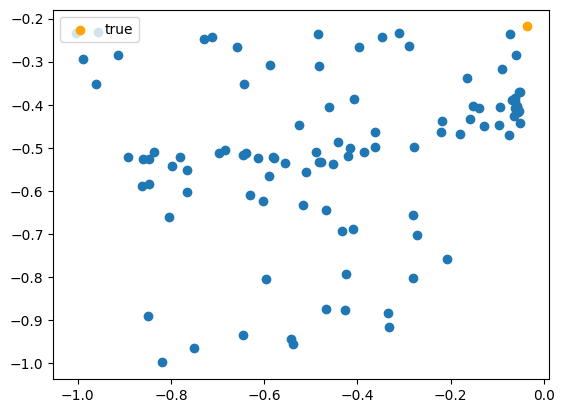

In [91]:
plt.scatter(init_sample_discrepancy_all[:,0],init_sample_discrepancy_all[:,1])  
real_dis = minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[7]), X_response=real_response)
plt.scatter(real_dis[0][0],real_dis[0][1],color='orange',label='true')
plt.legend(loc=2)
plt.show()

Now the initial data is dispersively located around $[-1,0]\times [-1,0]$.

**MOBOLFI training**

In [30]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.optim import optimize_acqf

We have generated a training dataset already, if you want to use it then just uncomment the chunks below


In [42]:
# import pandas as pd

df_X = pd.read_csv("em_mobolfi_train_X.csv",header=None)
df_Y = pd.read_csv("em_mobolfi_train_Y.csv",header=None)
init_sample_theta_all = df_X.to_numpy()[:100,:] 
init_sample_discrepancy_all = df_Y.to_numpy()[:100,:]
print(pd.DataFrame(init_sample_discrepancy_all).describe())

                0           1
count  100.000000  100.000000
mean    -0.450338   -0.510174
std      0.278534    0.191454
min     -1.004000   -0.997660
25%     -0.645454   -0.585077
50%     -0.456389   -0.499144
75%     -0.201533   -0.390925
max     -0.051156   -0.230137


In [ ]:
# When discrepancy design are L1 norm 
# import pandas as pd
# df_X = pd.read_csv("em_mobolfi_train_X_S1.csv",header=None)
# df_Y = pd.read_csv("em_mobolfi_train_Y_S1.csv",header=None)
# init_sample_theta_all = df_X.to_numpy()[:170,:] 
# init_sample_discrepancy_all = df_Y.to_numpy()[:170,:]
# print(pd.DataFrame(init_sample_discrepancy_all).describe())

In [43]:
X = torch.from_numpy(init_sample_theta_all)
Y = torch.from_numpy(init_sample_discrepancy_all)
train_X = X.double()
train_Y = Y.double()

In [151]:
real_theta_u = [real_theta[0],real_theta[3],real_theta[5],real_theta[6],real_theta[7]]

In [45]:
lows_u = [0,-3,-3,-3,-2]
highs_u = [5,5,5,5,6]
highs_u

[5, 5, 5, 5, 6]

In [46]:
ref_point = list(init_sample_discrepancy_all.min(axis=0)-0.1)
bounds = torch.tensor([lows_u,highs_u],dtype=torch.double)

In [1]:
import time
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 1 # to test difference of infernece with different number of iterations, change this value
qr =0 # rejection rate, in each iteration the BO acquistion is rejected with probability qr, if the actual objective value of the acquisition point doesn't appear to be small (i.e. no improvement made from BO)
# Again this is used in real world data example, set it to value between 0 to 1 if you want to use the rejection in BO. 

for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Define the acuisition function using current training data
    qNEHVI = qNoisyExpectedHypervolumeImprovement(gp, ref_point, train_X)

    candidate, acq_value = optimize_acqf(
      qNEHVI, bounds=bounds, q=1, num_restarts=10, raw_samples=100,)
    
    # reject aquisition points if real discrepancy is too large


    # Include new acuisition into training data
    
    candidate_X = candidate.flatten().numpy()
    
    candidate_Y = minus_simluated_discrepancy(theta = ([candidate_X[0], real_theta[1]], real_theta[2],[candidate_X[2],candidate_X[3]],
                                                    [candidate_X[1],real_theta[4]], candidate_X[-1]),X_response=real_response)                                              
    candidate_Y = torch.from_numpy(candidate_Y)
    
    # with probability qr the new acquisition will be accepted if the simulation discrepancy value (Y) is small enough (smllaer than the qr quantile)
    # with probability 1-qr the new acquisition will be dicrectely included into training data
    if np.random.uniform(low=0,high=1,size=1) < qr:
   
        if candidate_Y[0][0] > torch.quantile(train_Y,q=qr,dim=0).tolist()[0] or candidate_Y[0][1] > torch.quantile(train_Y,q=qr,dim=0).tolist()[1]:
            print("Acquisition of Iter {} will be included in training data for further training".format(i+1))
            train_X = torch.cat((train_X, candidate)).double()
            train_Y = torch.cat((train_Y, candidate_Y)).double()
        else:
            print("Acquisition of Iter {} will not be included in training data".format(i+1))
    else:
        train_X = torch.cat((train_X, candidate)).double()
        train_Y = torch.cat((train_Y, candidate_Y)).double()


    # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
    if i % 10 == 0:
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))




print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


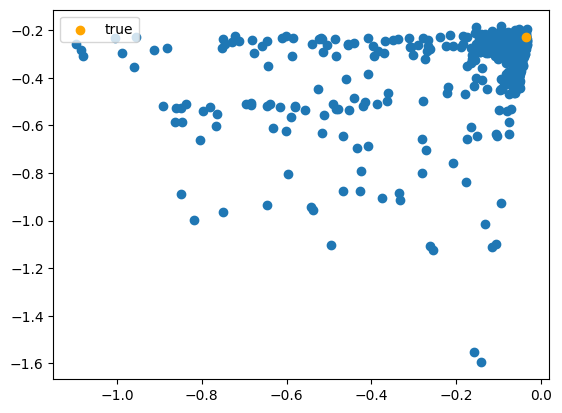

In [ ]:
# Expectedly, training data should cover the neighborhood of true param simulation's discrepancy point
plt.scatter(train_Y[:,0],train_Y[:,1])
plt.scatter(real_dis[0][0],real_dis[0][1],color='orange',label='true')
# plt.xlim(-1,0)
plt.legend(loc=2)
plt.show()

In [51]:
# The trained GP model
import pickle
gp = pickle.load(open('em_mobolfi_gp_model.sav', 'rb'))
df_X = pd.read_csv("em_mobolfi_train_X.csv",header=None).to_numpy()
df_Y = pd.read_csv("em_mobolfi_train_Y.csv",header=None).to_numpy()
train_X = df_X
train_Y = df_Y

c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

In [ ]:
# The trained GP model for an alternative disrepancies design

# gp = pickle.load(open('em_mobolfi_gp_model_S1.sav', 'rb'))
# df_X = pd.read_csv("mobolfi_train_X_S1.csv",header=None).to_numpy()
# df_Y = pd.read_csv("mobolfi_train_Y_S1.csv",header=None).to_numpy()
# train_X = df_X.double()
# train_Y = df_Y.double()

In [596]:
df = pd.DataFrame(train_X)
df.describe()

0           1           2           3           4
count  701.000000  701.000000  701.000000  701.000000  701.000000
mean     2.641118   -0.256829    1.007478    0.824276    0.611367
std      1.806977    1.476122    2.752989    2.708083    1.951466
min      0.000000   -3.000000   -3.000000   -3.000000   -2.000000
25%      1.062325   -1.363134   -1.544919   -1.469198   -0.743687
50%      2.622689    0.178896    0.989799    0.651770    0.279977
75%      4.600239    0.608446    3.417424    3.146451    1.313294
max      5.000000    5.000000    5.000000    5.000000    6.000000

In [597]:
df = pd.DataFrame(train_Y)
df.describe()

0           1
count  701.000000  701.000000
mean    -0.149758   -0.351200
std      0.203906    0.160999
min     -1.096476   -1.596050
25%     -0.114711   -0.403037
50%     -0.063061   -0.295479
75%     -0.051807   -0.251792
max     -0.033358   -0.184612

In [598]:
gp.posterior(train_X[-1,:].view(1,-1)).mean

tensor([[-0.1019, -0.4268]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [599]:
training_results = np.zeros((train_Y.size()[0], 6))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood1 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][0]).log_prob(real_obj[0])
    botorchlikelihood2 = torch.distributions.Normal(loc=pred_obj[0][1], scale=pred_var[0][1]).log_prob(real_obj[1])
    botorchlikelihood = botorchlikelihood1+botorchlikelihood2
    training_results[i,:] = [i,real_obj[0].item(),real_obj[1].item(),pred_obj[0][0].item(),pred_obj[0][1].item(),botorchlikelihood.item()]

training_results

array([[ 0.00000000e+00, -6.89717683e-02, -3.89109589e-01,
        -6.86508819e-02, -3.87231706e-01,  1.03788140e+01],
       [ 1.00000000e+00, -3.62714600e-01, -4.97819635e-01,
        -3.74956187e-01, -5.11760770e-01, -2.04836877e+02],
       [ 2.00000000e+00, -5.18910477e-02, -4.41415525e-01,
        -4.95368552e-02, -4.22526747e-01, -1.77218228e+02],
       ...,
       [ 6.98000000e+02, -7.66122948e-02, -6.34611872e-01,
        -8.59013565e-02, -6.39566099e-01, -3.69806764e+01],
       [ 6.99000000e+02, -1.15718464e-01, -1.11122146e+00,
        -1.22424533e-01, -1.09748618e+00, -5.10336526e+01],
       [ 7.00000000e+02, -6.60880509e-02, -4.43401826e-01,
        -1.01877022e-01, -4.26847412e-01, -2.96930756e+01]])

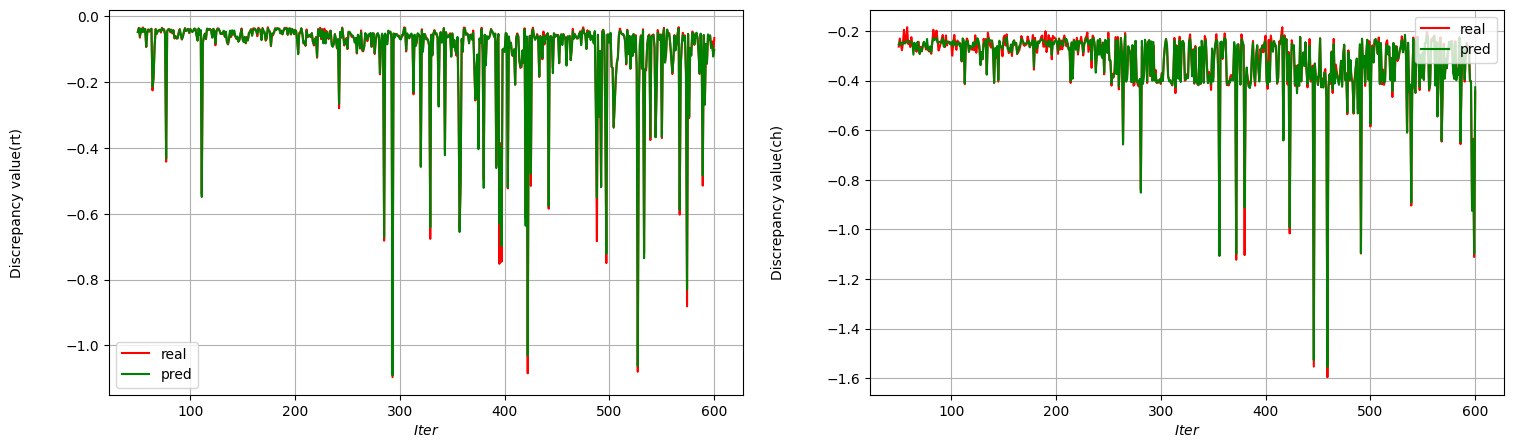

In [601]:
# Draw training curves
# Two curves should almost match together, menaing accurate prediction
num_init_samples = 100
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,1], color='red', label='real')
axs[0].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,3],'green',label='pred')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[0].set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)

axs[1].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,2], color='red', label='real')
axs[1].plot(training_results[num_init_samples+50:,0]-num_init_samples, training_results[num_init_samples+50:,4],'green',label='pred')
axs[1].legend(loc=1,fontsize=fs)
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[1].set_ylabel(r'Discrepancy value(ch)',fontsize=font_size_text,rotation='vertical',labelpad=30)


plt.show()

In [603]:
#estimate covaraince using the latest candidate

Y_cov = np.zeros((100,number_of_discrepancies))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(100):
    
    Y_cov[i,:] = minus_simluated_discrepancy(theta = ([X_cov[0],X_cov[1]], real_theta[2],[X_cov[3],X_cov[4]],
                                                    [X_cov[2],real_theta[4]], X_cov[-1]))

cov_est_noise = np.cov(Y_cov, rowvar = False)

In [604]:
cov_est_noise

array([[ 2.67928260e-06, -6.35925101e-06],
       [-6.35925101e-06,  4.88093572e-04]])

In [605]:
# An optinal solution to find correlation between output dimensions (rt and ch)
# Estimate the correlation separately by applying covariance formula ot train_Y
cov_est_output = np.cov(train_Y, rowvar = False)
cov_est_output

array([[0.04157757, 0.00965122],
       [0.00965122, 0.02592052]])

As iteration goes, it is clear to see the predictive discrepancies values are decreasing and gradually clsoe to real_dis, which is expected to see in theory (consistency).

But a good surrogate is not our ultimate target, we want "good" params that attain high likelihood values, and generate high similarity data, i.e. discrepancies very small.

So, the next step is to infer params and test their performance.

**Parameter inference**

We define the approximate posterior function first, and draw MCMC sample parameters from the approximate posterior distribution.

In [48]:
# We leave the training results on github to construct approxiamte likelihood
cov_est_noise = np.loadtxt('em_mobolfi_cov_est_noise.txt', dtype=np.dtype('float64'))
cov_est_noise

tol = np.loadtxt('em_mobolfi_1quantiletol.txt', dtype=np.dtype('float64'))
tol = tol.reshape(-1).tolist()
tol

[-0.037281919492701, -0.220011415525115]

In [ ]:
# # We leave the training results on github to construct approxiamte likelihood for antother design of discrepancies
# cov_est_noise = np.loadtxt('em_mobolfi_cov_est_noise_S1.txt', dtype=np.dtype('float64'))
# cov_est_noise

# tol = np.loadtxt('em_mobolfi_10quantiletol_S1.txt', dtype=np.dtype('float64'))
# tol = tol.reshape(-1).tolist()
# tol

In [310]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is p(y_obs|theta), we have no means to compute likelihood for y!=y_obs, because GP model is trained by y_obs
tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)


from scipy.stats import multivariate_normal

def approximate_log_likelihood(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([[variances[0][0].item(),covariance],
                    [covariance,variances[0][1].item()]])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0],-tol[1]])]).reshape(-1)
  return log_likelihood


[-0.0347972792010356, -0.206107305936073]


In [616]:
approximate_log_likelihood(theta=train_X[-1,:].view(-1)) 

tensor([-8.3184])

In [620]:
approximate_log_likelihood(theta=torch.Tensor(real_theta_u).view(-1)) # should be large and larger than value of the chunk above

tensor([-2.9590])

In [624]:
minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[7]), X_response=real_response)

array([[-0.03634422, -0.24092466]])

In [625]:
real_theta_u 

[0.2120024,
 0.5799932,
 2.0627080901415162,
 1.1012555255708283,
 0.7333077884122489]

In [314]:
lls = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    lls[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(lls)
crt_median = df_describe.median()
df_describe.describe()

c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:862: RuntimeWarning: divide by zero encountered in log
  out = np.log(cdf)


0
count  601.000000
mean         -inf
std           NaN
min          -inf
25%    -33.593388
50%    -19.863939
75%     -7.807547
max     -2.167338

In [626]:
#Test likelihood
lls = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    lls[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(lls)
crt_median = df_describe.median()
df_describe.describe()


0
count  701.000000
mean         -inf
std           NaN
min          -inf
25%    -21.750740
50%    -13.205729
75%     -5.321056
max     -2.305997

The prior density is defined to be product of each marginal priors (assume parameters are indep).

In [629]:
lows_u_prior = [0,  -3, -3, -3, -2]
highs_u_prior = [5,5 , 5, 5, 6]


In [631]:
def log_prior(theta):# theta is 1d tensor
    
    
    lp = 0
    for i in range(theta.size()[0]):
        if theta[i]<lows_u_prior[i] or theta[i]>highs_u_prior[i]:
            lp = torch.Tensor([-1e12])[0]
            return torch.Tensor([-1e12])[0]
 
    
    
    return lp

In [635]:
#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


0
count  701.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

In [636]:
def approximate_log_posterior(theta):
  ll = approximate_log_likelihood(theta)
  lprior = log_prior(theta)
  lp = lprior + ll
  return lp

In [821]:
approximate_log_posterior(theta=torch.Tensor(real_theta_u).view(-1))

tensor([-2.9590])

In [786]:
# Marginal approximate llk

tol = torch.quantile(train_Y,q=0.95,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)

def approximate_log_likelihood_rt(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][0]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item1 = (-tol[0]-means[0][0])/torch.sqrt(variances[0][0]+torch.Tensor(cov_noise)[0][0])
  prob1 = 0.5 * (1 + torch.erf(item1 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob1)
  return log_likelihood

def approximate_log_likelihood_ch(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][1]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item2 = (-tol[1]-means[0][1])/torch.sqrt(variances[0][1]+torch.Tensor(cov_noise)[1][1])
  prob2 = 0.5 * (1 + torch.erf(item2 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob2)
  return log_likelihood

[-0.03735093535420262, -0.2214497716894981]


In [791]:
print(approximate_log_likelihood_rt(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood_rt(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above

print(approximate_log_likelihood_ch(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood_ch(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above


likelihoods_rt = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_rt[i] = approximate_log_likelihood_rt(param)

df_describe = pd.DataFrame(likelihoods_rt)
print(df_describe.describe())

likelihoods_ch = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_ch[i] = approximate_log_likelihood_ch(param)

df_describe = pd.DataFrame(likelihoods_ch)
print(df_describe.describe())


def approximate_log_posterior_rt(theta):
  ll = approximate_log_likelihood_rt(theta)
  lprior = log_prior(theta)
  lp = lprior + ll #- prior_median.item() why we need to abstract such item
  return lp

def approximate_log_posterior_ch(theta):
  ll = approximate_log_likelihood_ch(theta)
  lprior = log_prior(theta)
  lp = lprior + ll #- prior_median.item()
  return lp

tensor(-1.8018, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-0.6941, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-5.8066, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-1.4587, dtype=torch.float64, grad_fn=<LogBackward0>)
                0
count  701.000000
mean         -inf
std           NaN
min          -inf
25%     -6.530684
50%     -1.875296
75%     -1.311063
max     -0.645945
                0
count  701.000000
mean         -inf
std           NaN
min          -inf
25%    -14.563384
50%     -4.091007
75%     -1.570212
max     -0.519982


DeMCMC

We use Differential evolution MCMC (DeMCMC) to draw samples from the approxiamte posterior for inference. This MCMC method is widely sued in learning sequential sampling models (SSMs). We do not require any specific sampling method or inference method. In reproduction, it's up to your choice to use any other inference method.

In [798]:
from joblib import Parallel, delayed

In [834]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm


class DEMCMC:

    def __init__(self, param_prior, param_hyper, post_fun, post_type,
                 param_num, chain_num, iter_num,
                 burn_in, migrate_rate, gamma, epsilon_b):
        """
        :param param_prior: a list of strings. list length should be the same as param_num.
                        Only two types prior distribution are available now.
                        "norm", for normal distribution prior.
                        "unif", for uniform distribution prior.
        :param param_hyper: a  (param_num,2) array. Entries are float type.
                        X[i,0] is the mean (or lower bound) of norm (uniform) distribution;
                        X[i,1] is the sd (or upper bound) of the norm (uniform) distribution;

        :param post_fun: a python function for posterior calculation

        :param post_type: bool type
                    post_type = 0, if the posterior returns from 0 to 1.
                    post_type = 1, if the posterior returns log-value.
        :param post_module: string
                    name of module contains the posterior function
        :param param_num: int type.
                    The number of estimable parameters. parameters with known fixed number were included.
        :param chain_num: int type.
                    The number of chains. When n<6,the chain_num = 24; otherwise, chain_num = 3*param_num.
        :param iter_num: int type.
                    The number of iteration.
        :param burn_in: int type.
                    The number of iteration for burn-in period. This part will discard for posterior sampling.
                    Moreover, migration step happens during burn-in period to facilitate convergence
        :param migrate_rate: float type. range from 0 to 1
                    The rate of migration step frequency during burn-in period.
        :param gamma: float type. A hyperparameter of De-MCMC crossover step. gamma = 2.38/sqrt(2*param_num)
        :param epsilon_b: float type. A hyperparameter of De-MCMC crossover step. epsilon \sim uniform[-epsilon_b,epsilon_b]
        """

        self.param_num = param_num
        self.chain_num = chain_num
        self.iter_num = iter_num
        self.burn_in = burn_in
        self.migrate_rate = migrate_rate
        self.gamma = gamma
        self.epsilon_b = epsilon_b
        self.param_prior = param_prior
        self.param_hyper = param_hyper
        self.postfun = post_fun
        self.post_type = post_type


    def log_poster(self, theta):
        """
        :param theta: a list. input of posterior function
        :return: float type. the log-posterior for the dataset given input theta
        """
        if self.post_type:
            # log-posterior is directly used.
            res = self.postfun(theta)
            if np.isnan(res):
                res = -np.inf
                print("Warning: A log-posterior input is NaN. The system will drop it.")
            elif res < -1e11:
                res = -np.inf
                print("The log-posterior input is less than -1e11.")
        else:
            # log-posterior is calculated.
            if np.isnan(self.postfun):
                print("Warning: A posterior input is NaN. The system will drop it.")
                res = -np.inf
            elif self.postfun < 1e-16:
                print("The posterior input is less than 1e-16.")
                res = -np.inf
            else:
                res = np.log(self.postfun(theta))

        return res

    def draw_prior(self, num, prior, hyper):
        '''
        return the random draw from prior
        :param num: int type. the number of random samples.
        :param prior: a string,either "norm" or "unif"
        :param hyper: array(1,2).
                    hyper[0] = mean of norm distribution (or lower bound of uniform);
                    hyper[1] = sd of norm distribution (or upper bound of uniform);
        :return: an array (num,1).
        '''
        if prior == "norm":
            res = np.random.normal(loc=hyper[0], scale=hyper[1], size=num)
            # res = scipy.stats.truncnorm.rvs(a = (0-hyper[0])/hyper[1], b = (200-hyper[0])/hyper[1] , loc= hyper[0], scale=hyper[1],size = num)

        elif prior == "unif":
            res = np.random.uniform(low=hyper[0], high=hyper[1], size=num)
        else:
            print("error: the prior shape is unkown.")
            res = np.nan

        return res


    def initial_chains(self):
        """
        A function to return  for initial value
          :return: a list, whose first and only element is a (chain_num, param_num) matrix
        """
        # Initialize chains. The last column is for likelihood

        
        
        ###########################################################################
        chain_list = []
          # check input
        if (len(self.param_prior) != self.param_num) | (np.shape(self.param_hyper)[0] != self.param_num):
            print("error: The parameter prior or hyper input length is inconsistent with parameter number.")
            
        elif np.shape(self.param_hyper)[1] != 2:
            print("error: The dimension of hyperparameters are inconsistent with design, ",
                  "please check `inital_chains` function for details.")
            
        else:
            theta_0 = np.zeros((self.chain_num, self.param_num + 1))
             # calculate the log-posterior for chain_num parameter sets
            for i in range(self.param_num):
                    theta_0[:, i] = self.draw_prior(self.chain_num, self.param_prior[i], self.param_hyper[i, :]).tolist()
                   
            for j in range(self.chain_num):
                theta_0[j,self.param_num] = self.log_poster(theta_0[j,:-1])
                # print(theta_0[i,self.param_num])
            # theta_0[:, self.param_num] = np.apply_along_axis(lambda x: self.log_poster(x[:-1]), 1, theta_0).reshape(self.chain_num, ) 


            index_p = [-1]*self.chain_num     
            index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
            
          
            index = []
            for j in index_p:
                if j>=0:
                    index.append(j)

            while len(index) > 0:
                for i in range(self.param_num):
                    theta_0[index, i] = self.draw_prior(len(index), self.param_prior[i], self.param_hyper[i, :]).tolist()
                    # print(theta_0[i,self.param_num])
                    # calculate the log-posterior for chain_num parameter sets
                for j in index:
                    theta_0[j,self.param_num] = self.log_poster(theta_0[j, :-1])

                # theta_0[index, self.param_num] = np.apply_along_axis(lambda x: self.log_poster(x[:-1]), 1,
                #                                                 theta_0[index,:]).reshape(len(index), )
                index_p = [-1]*self.chain_num
                index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
                
                
                index = []
                for j in index_p:
                    if j >= 0:
                        index.append(j)
          


            chain_list.append(pd.DataFrame(theta_0))
           
        return chain_list


    def crossover_step(self, chain_index, last_step_chains):
        """
        For a given chain, randomly draw other two chains to get the difference value, the proposed value = chain_value + difference + epsilon
        :param chain_index: int type. The index of the updated chain at this step
        :param last_step_chains: A dataframe.
        :return: the value of chain of this step.It is a vector whose length is param_num+1.

        """
        # last_step_chains = chain_list[last_step_index]
        # get the previous parameter values in this chain
        theta_prev = np.array(last_step_chains.iloc[chain_index, :-1])
        # Randomly draw two chain indices from all chains except the current chain
        prob = [1 / (self.chain_num - 1)] * self.chain_num
        prob[chain_index] = 0
        de_ChainIndex = np.random.choice(range(self.chain_num), size=2, replace=False, p=prob)

        theta_m = np.array(last_step_chains.iloc[de_ChainIndex[0], :-1])
        theta_n = np.array(last_step_chains.iloc[de_ChainIndex[1], :-1])

        # Generate new theta; here, there are npar parameters to estimate in total
        epsilon = np.random.uniform(-self.epsilon_b, self.epsilon_b, self.param_num)
        theta_proposed = theta_prev + self.gamma * (theta_m - theta_n) + epsilon

        proposed_post = self.log_poster(theta_proposed)
        if np.isnan(proposed_post):  # avoid nan.
            proposed_post = -np.inf
        prev_post = last_step_chains.iloc[chain_index, self.param_num]

        # Acceptance rate
        alpha = np.random.uniform()
        ratio = proposed_post - prev_post
        if np.isnan(ratio):
            print("Warning: please check the initial matrix.")
            ratio = -1
        elif np.isinf(ratio) | (ratio <= -1e12):
            ratio = -1
        else:
            ratio = np.exp(ratio)
        if alpha > ratio:
            # reject the proposed value
            temp = np.append(theta_prev, prev_post)

        else:
            temp = np.append(theta_proposed, proposed_post)

        return temp



    def migration_step(self, last_step_chains):

        """
        migration step is optional for De-MCMC, but very useful for the convergence.
        Normally, every 10 or 5 crossover steps during the burn-in stage, one migration step can be used.
        :param last_step_chains: A chain_num by (param_num +1) Dataframe.
         :return: A Dataframe, whose dimension is chain_num by (param_num +1). The last column is log-posterior value.
        """
        temp = last_step_chains
        # select the migration scale, from 2 to chain_num
        mig_num = np.random.randint(low=1, high=self.chain_num)+1
        # randomly draw mig_num chains for migration.
        mig_index = np.random.choice(range(self.chain_num), size=mig_num, replace=False)

        prev_theta = np.array(temp.iloc[mig_index, :-1])
        prev_post = temp.iloc[mig_index, -1].tolist()
        epsilon = np.random.uniform(low=-self.epsilon_b, high=self.epsilon_b, size=(mig_num, self.param_num))

        for i in range(mig_num):
            if i != (mig_num - 1):  # not the last item
                proposed_theta = prev_theta[(i + 1), :] + epsilon[i, :]
            else:
                proposed_theta = prev_theta[0, :] + epsilon[i, :]

            proposed_post = self.log_poster(proposed_theta)
            if np.isnan(proposed_post):  # aviod nan.
                proposed_post = -np.inf
            # whether to accept
            alpha = np.random.uniform()
            ratio = proposed_post - prev_post[i]
            if np.isnan(ratio):
                print("Warning: please check the initial matrix.")
                ratio = -1
            elif np.isinf(ratio) | (ratio <= -1e12):
                ratio = -1
            else:
                ratio = np.exp(ratio)

            if alpha < ratio:  # accept the proposed value
                temp.iloc[mig_index[i], :] = np.append(proposed_theta, proposed_post)
            else:
                temp.iloc[mig_index[i], :] = np.append(prev_theta[i, :], prev_post[i])

        return temp

    def De_MCMC(self) -> list:
        """
        This functions to for De-MCMC sampling to return a chain trace list.
       :return: A list with (iter_num+1) elements, each element is a Dataframe has chain_num rows and param_num+1 columns.
        """
        # initial chain_list
        chain_list = self.initial_chains()
       
        print("initialization is finished.")
       
        chain_add = chain_list[0]
        print(chain_list)
        for i in range(self.iter_num):
            chain_add = pd.DataFrame(Parallel(n_jobs=-1)(delayed(self.crossover_step)(row, chain_add) for row in range(self.chain_num)))
            # for j in range(self.chain_num):
                # chain_add1.iloc[j, :] = self.crossover_step(chain_index=j, last_step_chains=chain_add)
            if i%100 == 0:
                print(i, "iterations has been done.")
            chain_list.append(chain_add)
            if (i <= self.burn_in) & (np.random.uniform() < self.migrate_rate):
                # conduct migrate step
                chain_add = self.migration_step(chain_add)
                chain_list[i + 1] = chain_add
        return chain_list

In [4]:
# joint approximated llk
if __name__ == "__main__":
    param_num = 5
    chain_num = 15# This is just a simple example, normally the chain_num is 3*param_num
    iter_num = 10000#  
    burn_in = 6000 # 
    
    migrate_rate = 0.1 # 0.3 - 0.7
    gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
    epsilon_b = 1e-2
    param_prior = ["unif", "unif", "unif", "unif", "unif"]

    param_hyper = np.array([[0,5], [-3,5], [-3,5], [-3,5],[-2, 6]])
    def myll(theta):
        theta = torch.tensor(theta).view(-1)
        ll = approximate_log_posterior(theta)
        # ll = 0
        return ll.item()
 
    test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                  post_fun=myll, post_type=1,
                  chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                  burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)
    demcmc_sample_list = test_list.De_MCMC()
    

In [1022]:
# approximated llk for choice only
if __name__ == "__main__":

    param_num = 5
    chain_num = 15#3*param_num # This is just a simple example, normally the chain_num is 3*param_num
    iter_num = 10000
    burn_in = 6000
    migrate_rate = 0.1 # 0.3 - 0.7
    gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
    epsilon_b = 1e-2
 
    

    param_prior = ["unif",  "unif", "unif", "unif", "unif"]

    
   
   
    param_hyper = np.array([[0,5], [-3,5], [-3,5], [-3,5],[-2, 6]])
    def myll(theta):
        theta = torch.tensor(theta).view(-1)
        ll = approximate_log_posterior_ch(theta)
        
        
      
        return ll.item()
  
    test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                  post_fun=myll, post_type=1,
                  chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                  burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)

    demcmc_sample_list_ch = test_list.De_MCMC()
    
    print(demcmc_sample_list_ch)

initialization is finished.
[           0         1         2         3         4         5
0   1.938919  0.404912 -0.714949  0.912359  5.385000 -0.259415
1   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
2   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
3   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
4   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
5   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
6   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
7   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
8   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
9   1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
10  1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
11  1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
12  1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
13  1.938722  0.405317 -0.715217  0.912230  5.385733 -0.259521
14  2.005208  0.371942 -0.

In [ ]:
# approximated llk for ch only
param_num = 5
chain_num = 15  # This is just a simple example, normally the chain_num is 3*param_num
iter_num = 1000 
burn_in = 200 
migrate_rate = 0.1 # 0.3 - 0.7
gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
epsilon_b = 1e-2

param_prior = ["unif", "unif", "unif", "unif", "unif"]

param_hyper = np.array([[0,5], [-3,5], [-3,5], [-3,5],[-2, 6]])


def myll(theta):
        theta = torch.tensor(theta).view(-1)
        ll = approximate_log_posterior_rt(theta)
   
        return ll.item()
    

    
test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                  post_fun=myll, post_type=1,
                  chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                  burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)

demcmc_sample_list_rt = test_list.De_MCMC()

In [83]:
# # # # We simulated MCMC results with iter_num = 1e4, burn-in = 6000, chain_num = 15 
# # # # The stored data format is a matrx with  (iter_num+1)*(chain_num +2) rows and (num_parameter+1). each iteration is vertically stacked. The last two row of each iteration is the mean and std of chains for each parameter.

# coords_demcmc_dgn = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain15_1e4.txt', dtype=np.dtype('float64'))
# coords_demcmc_dgn_ch = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain15_1e4_CH.txt', dtype=np.dtype('float64'))
# coords_demcmc_dgn_rt = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain15_1e4_RT.txt', dtype=np.dtype('float64'))

# # return back to demcmc_sample_list,demcmc_sample_list_ch,demcmc_sample_list_rt
# param_num = 5
# chain_num = 15
# iter_num = 10000
# burn_in = 6000

# thin = np.arange(stop = int(iter_num+1),step = 1).tolist()
# demcmc_sample_list = []
# demcmc_sample_list_ch = []
# demcmc_sample_list_rt = []

# for i in thin:

#     sample = coords_demcmc_dgn[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     sample_ch = coords_demcmc_dgn_ch[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     sample_rt = coords_demcmc_dgn_rt[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     demcmc_sample_list.append(pd.DataFrame(sample))
#     demcmc_sample_list_ch.append(pd.DataFrame(sample_ch))
#     demcmc_sample_list_rt.append(pd.DataFrame(sample_rt))
    

In [80]:
# # for MOBOLFI approximate llk with L1 norm discrepancy result
# coords_demcmc_dgn_S1 = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain12_1e4_S1.txt', dtype=np.dtype('float64'))
# coords_demcmc_dgn_ch_S1 = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain12_1e4_CH_S1.txt', dtype=np.dtype('float64'))
# coords_demcmc_dgn_rt_S1 = np.loadtxt('em_allchains_demcmcsample_mobolfiapproxllk_chain12_1e4_RT_S1.txt', dtype=np.dtype('float64'))


# # return back to demcmc_sample_list,demcmc_sample_list_ch,demcmc_sample_list_rt
# param_num = 5
# chain_num = 15
# iter_num = 10000
# burn_in = 6000

# thin = np.arange(stop = int(iter_num+1),step = 1).tolist()
# demcmc_sample_list_S1 = []
# demcmc_sample_list_ch_S1 = []
# demcmc_sample_list_rt_S1 = []

# for i in thin:

#     sample = coords_demcmc_dgn_S1[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     sample_ch = coords_demcmc_dgn_ch_S1[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     sample_rt = coords_demcmc_dgn_rt_S1[(i*(chain_num+2)):(i*(chain_num+2)+chain_num),:]
#     demcmc_sample_list_S1.append(pd.DataFrame(sample))
#     demcmc_sample_list_ch_S1.append(pd.DataFrame(sample_ch))
#     demcmc_sample_list_rt_S1.append(pd.DataFrame(sample_rt))

Achieve stationary posteior samplers 

In [ ]:
param_num = 5
chain_num = 15#3*param_num # This is just a simple example, normally the chain_num is 3*param_num
iter_num = 10000
burn_in = 6000


coords_demcmc_last = np.zeros((1, num_of_parameters+1))
coords_demcmc_last_ch = np.zeros((1, num_of_parameters+1))
coords_demcmc_last_rt = np.zeros((1, num_of_parameters+1))
thin = random.sample(np.arange(int((burn_in+1)*1.3+1),int(iter_num), 1).tolist(),k = 300) # sampling after burn-in period

for i in thin:
    sample = demcmc_sample_list[i].iloc[:,:]
    sample_ch = demcmc_sample_list_ch[i].iloc[:,:]
    sample_rt = demcmc_sample_list_rt[i].iloc[:,:]
    coords_demcmc_last = np.concatenate((coords_demcmc_last,sample),axis=0)
    coords_demcmc_last_ch = np.concatenate((coords_demcmc_last_ch,sample_ch),axis=0)
    coords_demcmc_last_rt = np.concatenate((coords_demcmc_last_rt,sample_rt),axis=0)

In [84]:
# # for MOOLFI approxiate llk MCMC based on L1-norm discrepancy design
# param_num = 5
# chain_num = 15#3*param_num # This is just a simple example, normally the chain_num is 3*param_num
# iter_num = 10000
# burn_in = 6000


# coords_demcmc_last_S1 = np.zeros((1, num_of_parameters+1))
# coords_demcmc_last_ch_S1 = np.zeros((1, num_of_parameters+1))
# coords_demcmc_last_rt_S1 = np.zeros((1, num_of_parameters+1))
# thin = random.sample(np.arange(int((burn_in+1)*1.3+1),int(iter_num), 1).tolist(),k = 300) # sampling after burn-in period

# for i in thin:
#     sample = demcmc_sample_list_S1[i].iloc[:,:]
#     sample_ch = demcmc_sample_list_ch_S1[i].iloc[:,:]
#     sample_rt = demcmc_sample_list_rt_S1[i].iloc[:,:]
#     coords_demcmc_last_S1 = np.concatenate((coords_demcmc_last_S1,sample),axis=0)
#     coords_demcmc_last_ch_S1 = np.concatenate((coords_demcmc_last_ch_S1,sample_ch),axis=0)
#     coords_demcmc_last_rt_S1 = np.concatenate((coords_demcmc_last_rt_S1,sample_rt),axis=0)
    

Import demcmc samplers of closed-form MLBA llk.

In [60]:
coords_demcmc_mlbaclosed = pd.read_csv('em_allchains_demcmcsamples_closedform_chain15_1e4.csv', dtype=np.dtype('float64'))

coords_demcmc_mlbaclosed = pd.DataFrame(coords_demcmc_mlbaclosed)
 # number_chain * [(npar+1)
#(9, 56008)
M = int(coords_demcmc_mlbaclosed.shape[1]/(param_num+1))
tmp = []
i = 0

while i<M:
    tmp.append(pd.DataFrame(coords_demcmc_mlbaclosed.iloc[:,((num_of_parameters+1)*i):((num_of_parameters+1)*(i+1))].to_numpy(),columns = ['betaTC', "betaDR","zetaICEV","lam1","log_(b-A)","llk"])) 
    

    i +=1


thin = random.sample(np.arange(int((6000)*1.3),int(M), 1).tolist(),k = 300) #2700 samples
tmp1 = [tmp[index] for index in thin]
coords_demcmc_mlbaclosed = pd.concat(tmp1,ignore_index=True)


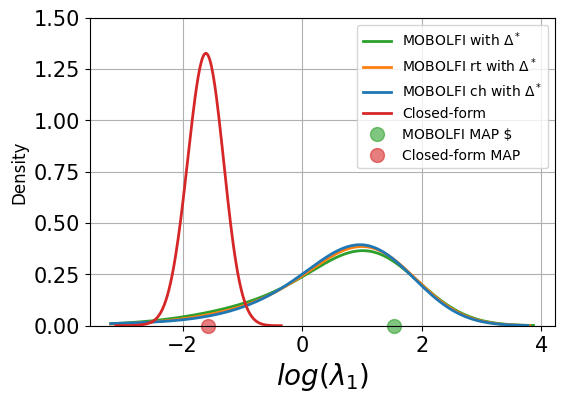

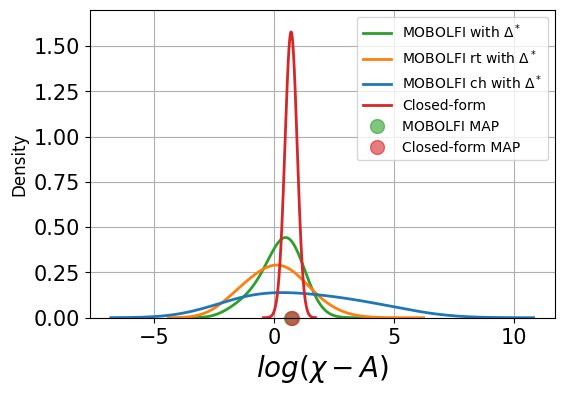

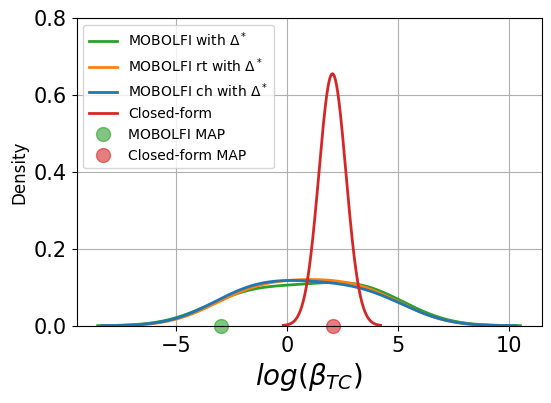

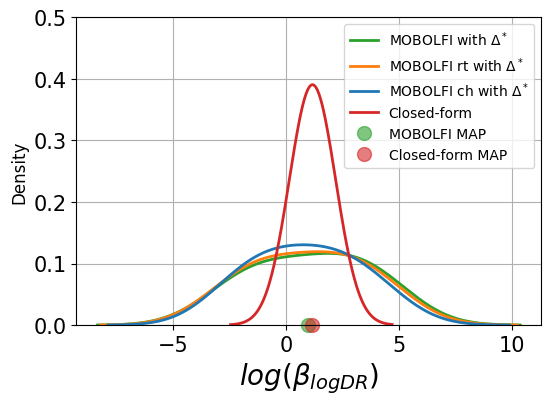

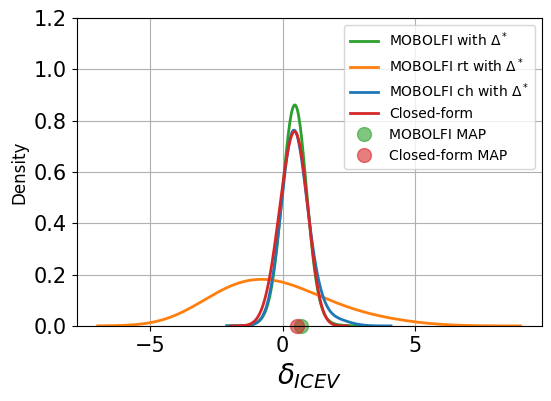

In [75]:
import seaborn as sns
font_size_text = 20
fs=10
 # MAP's index

upper_b = [1.5,1.7,0.8,0.5,1.2]
param_name = ["lam1","delta","TC","DR","chi"]
param_list = [r'$log(\lambda_1)$',r'$log (\chi-A)$',r'$log(\beta_{TC})$',r'$log(\beta_{log DR})$',r'$\delta_{ICEV}$']
mobolfi_llk_index = [0,4,2,3,1]
# betaTC,betaDR,delta,lam1,zeta

closed_llk_index = [3,4,0,1,2]
point_coords_demcmc = coords_demcmc_last[1:,:]
point_coords_demcmc_rt = coords_demcmc_last_rt[1:,:]
point_coords_demcmc_ch = coords_demcmc_last_ch[1:,:]
point_coords_demcmc_cf = coords_demcmc_mlbaclosed




index_joint = np.argmax(point_coords_demcmc[:,-1])
index_rt = np.argmax(point_coords_demcmc_rt[:,-1])
index_ch = np.argmax(point_coords_demcmc_ch[:,-1])
index_cf = np.argmax(point_coords_demcmc_cf.iloc[:,-1])

for i in range(num_of_parameters):
    plt.figure(figsize=[6, 4])
    if mobolfi_llk_index[i] ==0:
        joint_index = (coords_demcmc_last[:,0]>0.001)
        rt_index = (coords_demcmc_last_rt[:,0]>0.001)
        ch_index = (coords_demcmc_last_ch[:,0]>0.001)
        
        sns.kdeplot(np.log(coords_demcmc_last[joint_index,mobolfi_llk_index[i]]) , label='MOBOLFI with $\Delta^*$',bw_adjust=4 ,color = "C2",clip = (-3.2,4),linewidth=2.0)
        sns.kdeplot(np.log(coords_demcmc_last_rt[rt_index,mobolfi_llk_index[i]]) , label='MOBOLFI rt with $\Delta^*$',bw_adjust=4,color = "C1",clip =(-3.2,4),linewidth=2)
        sns.kdeplot(np.log(coords_demcmc_last_ch[ch_index,mobolfi_llk_index[i]]) , label='MOBOLFI ch with $\Delta^* $',bw_adjust=4, color = "C0",clip =(-3.2,4),linewidth=2)
        sns.kdeplot(np.log(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]]) , label='Closed-form',bw_adjust=4, color = "C3",clip =(-3.2,4),linewidth=2)
        
        
        
        
        plt.plot([np.log(point_coords_demcmc[index_joint,mobolfi_llk_index[i]])],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP $',clip_on=False, color = "C2",alpha=.6,markersize = 10)
        # plt.plot([np.log(point_coords_demcmc_rt[index_rt,mobolfi_llk_index[i]])],[0],marker = 's',ls = 'none',label='MOBOLFI rt MAP',clip_on=False,color = "C1",alpha=.6,markersize = 10)
        # plt.plot([np.log(point_coords_demcmc_ch[index_ch,mobolfi_llk_index[i]])],[0],marker = 's',ls = 'none',label='MOBOLFI ch MAP',clip_on=False, color = "C0",alpha=.6,markersize = 10)
        plt.plot(np.log(point_coords_demcmc_cf.iloc[index_cf,closed_llk_index[i]]),[0],marker = 'o',ls = 'none',label='Closed-form MAP',clip_on=False,color = "C3",alpha=.6,markersize =10)
 
        
       
    else: 
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=4, color = "C2",linewidth=2)
        sns.kdeplot(coords_demcmc_last_rt[1:,mobolfi_llk_index[i]], label='MOBOLFI rt with $\Delta^*$',bw_adjust=4,color = "C1",linewidth=2)
        sns.kdeplot(coords_demcmc_last_ch[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=4, color = "C0",linewidth=2)
        

        
        if mobolfi_llk_index[i] ==1:
            sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=4, color = "C3",linewidth=2)
        elif mobolfi_llk_index[i] ==4:
             sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
        else:
             sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=30, color = "C3",linewidth=2)
             
             
        plt.plot([point_coords_demcmc[index_joint,mobolfi_llk_index[i]]],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP',clip_on=False, color = "C2",alpha=.6,markersize = 10)
        # plt.plot([point_coords_demcmc_rt[index_rt,mobolfi_llk_index[i]]],[0],marker = 's',ls = 'none',label='MOBOLFI rt MAP',clip_on=False,color = "C1",alpha=.6,markersize = 10)
        # plt.plot([point_coords_demcmc_ch[index_ch,mobolfi_llk_index[i]]],[0],marker = 's',ls = 'none',label='MOBOLFI ch MAP',clip_on=False, color = "C0",alpha=.6,markersize = 10)
        
        plt.plot(point_coords_demcmc_cf.iloc[index_cf,closed_llk_index[i]],[0],marker = 'o',ls = 'none',label='Closed-form MAP',clip_on=False,color = "C3",alpha=.6,markersize = 10)
        
       
    
  
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[i],fontsize=20)
    plt.ylabel("Density",fontsize=12)
    plt.legend()
    plt.ylim(0,upper_b[i])
 
   
    # plt.savefig('MLBA_em_post_'+param_name[i]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()


plt.show()





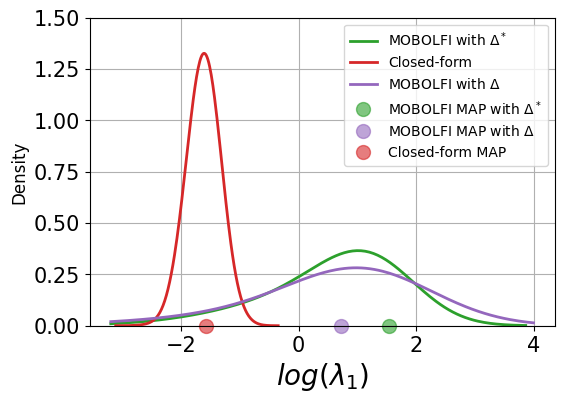

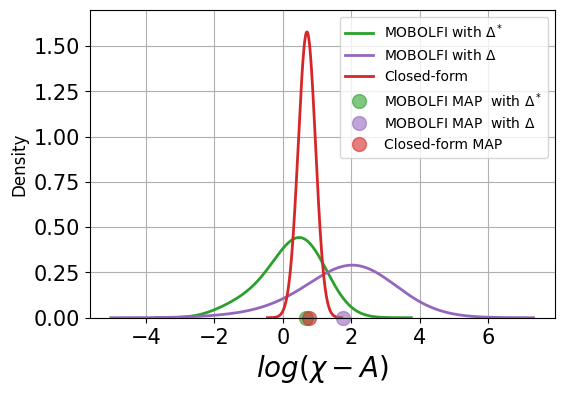

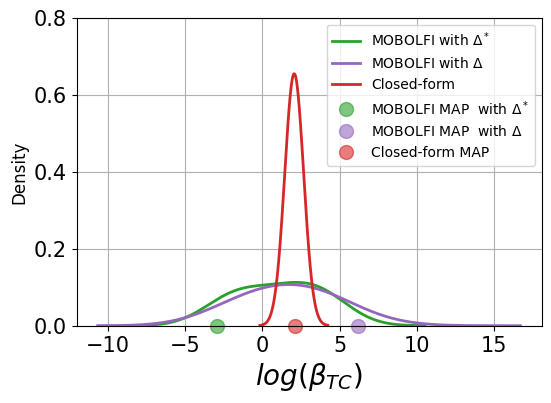

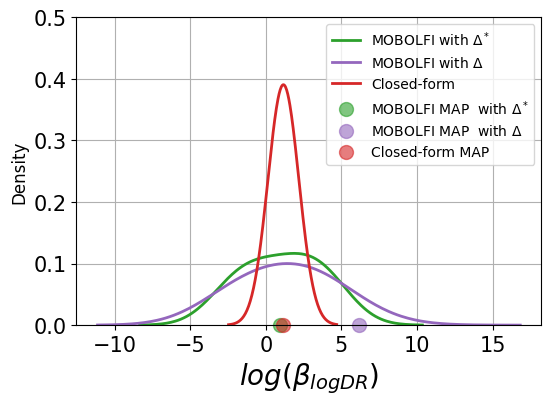

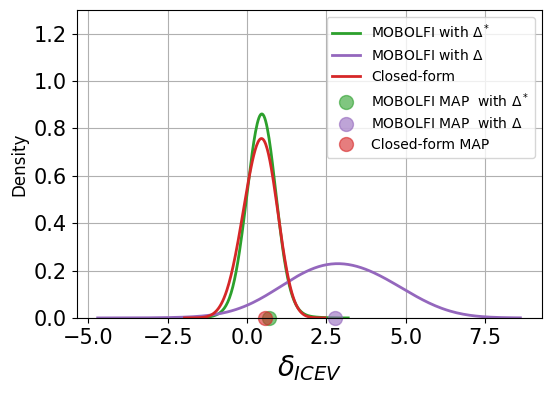

In [89]:
# comparison between different discrepancy design
# font_size_text = 20
# fs=10
#  # MAP's index

# upper_b = [1.5,1.7,0.8,0.5,1.3]
# param_name = ["lam1","delta","TC","DR","chi"]
# param_list = [r'$log(\lambda_1)$',r'$log (\chi-A)$',r'$log(\beta_{TC})$',r'$log(\beta_{log DR})$',r'$\delta_{ICEV}$']
# mobolfi_llk_index = [0,4,2,3,1]
# # betaTC,betaDR,delta,lam1,zeta

# closed_llk_index = [3,4,0,1,2]
# point_coords_demcmc = coords_demcmc_last[1:,:]
# point_coords_demcmc_cf = coords_demcmc_mlbaclosed
# point_coords_demcmc_S1 = coords_demcmc_last_S1[1:,:]


# index_joint_MAD = np.argmax(point_coords_demcmc_S1[:,-1])
# index_joint = np.argmax(point_coords_demcmc[:,-1])

# index_cf = np.argmax(point_coords_demcmc_cf.iloc[:,-1])
# param_name = ["lam1","log_chi","log_betaTC","log_betaDR","deltaICEV"]
# for i in range(num_of_parameters):
#     plt.figure(figsize=[6, 4])
#     if mobolfi_llk_index[i] ==0:
#         joint_index = (coords_demcmc_last[:,0]>0.001)
     
#         sns.kdeplot(np.log(coords_demcmc_last[joint_index,mobolfi_llk_index[i]]) , label='MOBOLFI with $\Delta^*$',bw_adjust=4 ,color = "C2",clip = (-3.2,4),linewidth=2.0)
#         sns.kdeplot(np.log(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]]) , label='Closed-form',bw_adjust=4, color = "C3",clip =(-3.2,4),linewidth=2)
        
#         sns.kdeplot(np.log(coords_demcmc_last_S1[1:,mobolfi_llk_index[i]]) , label='MOBOLFI with $\Delta$',bw_adjust=4 ,color = "C4",clip = (-3.2,4),linewidth=2.0)
        
#         plt.plot([np.log(point_coords_demcmc[index_joint,mobolfi_llk_index[i]])],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP with $\Delta^*$',clip_on=False, color = "C2",alpha=.6,markersize = 10)
#         plt.plot([np.log(point_coords_demcmc_S1[index_joint_MAD,mobolfi_llk_index[i]])],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP with $\Delta$',clip_on=False, color = "C4",alpha=.6,markersize = 10)
#         plt.plot(np.log(point_coords_demcmc_cf.iloc[index_cf,closed_llk_index[i]]),[0],marker = 'o',ls = 'none',label='Closed-form MAP',clip_on=False,color = "C3",alpha=.6,markersize =10)
      
        
       
#     else: 
#         sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=4, color = "C2",linewidth=2)
#         sns.kdeplot(coords_demcmc_last_S1[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta$',bw_adjust=4, color = "C4",linewidth=2)
#         if mobolfi_llk_index[i] ==1:
#             sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=4, color = "C3",linewidth=2)
#         elif mobolfi_llk_index[i] ==4:
#              sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
#         else:
#              sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=30, color = "C3",linewidth=2)
             
             
#         plt.plot([point_coords_demcmc[index_joint,mobolfi_llk_index[i]]],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP  with $\Delta^*$',clip_on=False, color = "C2",alpha=.6,markersize = 10)
        
#         plt.plot([point_coords_demcmc_S1[index_joint_MAD,mobolfi_llk_index[i]]],[0],marker = 'o',ls = 'none',label='MOBOLFI MAP  with $\Delta$',clip_on=False, color = "C4",alpha=.6,markersize = 10)
        
#         plt.plot(point_coords_demcmc_cf.iloc[index_cf,closed_llk_index[i]],[0],marker = 'o',ls = 'none',label='Closed-form MAP',clip_on=False,color = "C3",alpha=.6,markersize = 10)
        
       
    
  
#     plt.grid()
#     plt.tick_params(axis='both', labelsize=15)
#     plt.xlabel(param_list[i],fontsize=20)
#     plt.ylabel("Density",fontsize=12)
#     plt.legend()
#     plt.ylim(0,upper_b[i])
 
   
#     # plt.savefig('MLBA_em_post_comparison_'+param_name[i]+'.pdf',dpi = 1080,bbox_inches='tight') 

#     plt.show()


# plt.show()


Weak depedence of discpreancies for certain parameters

In [90]:
best_traning_point = point_coords_demcmc[index_joint,:-1] 
print("MOBOLFI MAP: ",point_coords_demcmc[index_joint,:])

print("closed-form MAP: ",point_coords_demcmc_cf.iloc[index_cf,:-1])


MOBOLFI MAP:  [ 4.65678207  0.70248709 -2.97392766  0.95287078  0.68772002 -2.24811769]
closed-form MAP:  betaTC       2.079286
betaDR       1.120661
zetaICEV     0.554597
lam1         0.207604
log_(b-A)    0.756851
Name: 1982, dtype: float64


In [91]:
# calculate discrepancies for MOBOLFI MAP

iter_test =1000 # number of repitations for each theta


dis_matrix_last = np.zeros((iter_test,2))

for i in range(iter_test):

    tmp_theta = best_traning_point 

    dis_matrix_last[i,:] = minus_simluated_discrepancy(theta=([tmp_theta[0], real_theta[1]], real_theta[2],[tmp_theta[2],real_theta[3]], [tmp_theta[1],real_theta[4]],tmp_theta[4]), X_response=real_response)

    if i%5==0:
        print("process"+str(i/iter_test*100)+"%.")
discprepancy_joint_MAP_last = pd.DataFrame(dis_matrix_last)
# discprepancy_joint_MAP_last.to_csv("em_MOBOLFI_discrepancy_MAP_1e3.csv",header=False,index=False)

In [365]:
# calculate discrepancies for MOBOLFI MAP

iter_test =1000 # number of repitations for each theta


dis_matrix_last_cf = np.zeros((iter_test,2))

for i in range(iter_test):
    dis_matrix_last_cf[i,:] = minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[7]), X_response=real_response)
  

    if i%5==0:
        print("process"+str(i/iter_test*100)+"%.")
discprepancy_cf_MAP_last = pd.DataFrame( dis_matrix_last_cf)
#  discprepancy_cf_MAP_last.to_csv("em_cf_discrepancy_MAP_1e3.csv",header=False,index=False)

In [93]:
# # load stored discrepancies of MAP 

# discprepancy_cf_MAP_last = pd.read_csv("em_cf_discrepancy_MAP_1e3.csv",header=None)
# discprepancy_joint_MAP_last = pd.read_csv("em_MOBOLFI_discrepancy_MAP_1e3.csv",header=None)


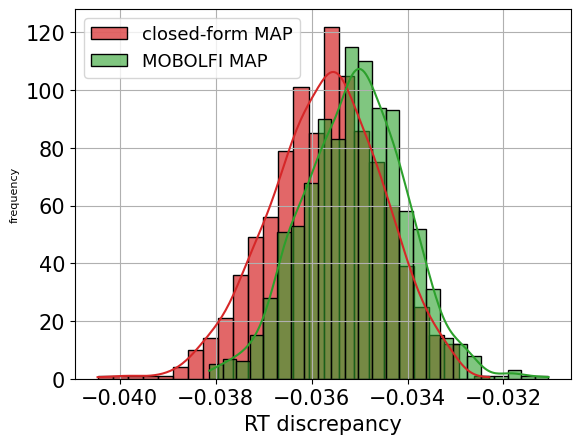

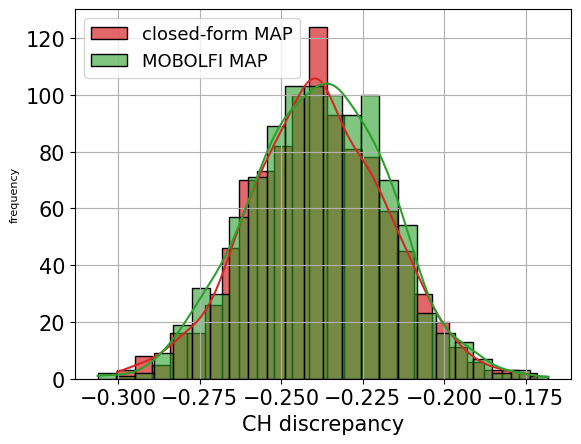

In [95]:
import seaborn as sns
from statistics import mode


sns.histplot(discprepancy_cf_MAP_last.iloc[:,0].to_numpy() , label='closed-form MAP', color = "C3",alpha =0.7, kde=True)
sns.histplot(discprepancy_joint_MAP_last.iloc[:,0].to_numpy() , label='MOBOLFI MAP', color = "C2",alpha =0.6, kde=True)
      
plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)

plt.ylabel("frequency",fontsize=8)
plt.xlabel("RT discrepancy",fontsize=15)


# plt.savefig('MLBA_em_post_MAP_CH.pdf',dpi = 1080,bbox_inches='tight') 

plt.show()

sns.histplot(discprepancy_cf_MAP_last.iloc[:,1].to_numpy() , label='closed-form MAP', color = "C3",alpha =0.7, kde=True)
sns.histplot(discprepancy_joint_MAP_last.iloc[:,1].to_numpy() , label='MOBOLFI MAP', color = "C2",alpha =0.6, kde=True)

plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)

plt.ylabel("frequency",fontsize=8)
plt.xlabel("CH discrepancy",fontsize=15)


# plt.savefig('MLBA_em_post_MAP_RT.pdf',dpi = 1080,bbox_inches='tight') 

plt.show()

check discrepancy dependence for each parameter when fixing others to MOBOLFI MAP

In [1389]:
coords_demcmc_last[index_joint,:]

array([ 4.26972193,  0.55885794, -2.93417911, -0.39818584,  0.6904296 ,
       -2.07309818])

In [1392]:

def parallel_disc_MOBOLFI(para_theta):
    tmp_theta = para_theta
    tmp=minus_simluated_discrepancy(theta=([tmp_theta[0], real_theta[1]], real_theta[2], [tmp_theta[2],tmp_theta[3]],[tmp_theta[1],real_theta[4]],tmp_theta[4]), X_response=real_response)[0]
    return(tmp)

In [1972]:
print(lows_u)
print(highs_u)

param_index = [0,1,2,3,4]
num_point = 14

iter_num = 100
MOBOLFI_index = [2,3,1,0,4]

param_name = [ 'log_betaTC', 'log_betaDR', 'deltaICEV','lam1', 'log_chi']
for i in param_index:

    test_theta = [-2.93417911, -0.39818584, 0.55885794, 4.26972193,   0.6904296] # log beta,delta,lam,log(chi-A)

    print(test_theta)
    dis_rt = np.zeros((iter_num,num_point))
    dis_ch = np.zeros((iter_num,num_point))
    candidate_para0 = np.linspace(lows_u[MOBOLFI_index[i]],highs_u[MOBOLFI_index[i]], num = 5)
    tmp_candidate_para_1 = candidate_para0[0:4]+0.1
    tmp_candidate_para_2 = candidate_para0[1:5]-0.1
    candidate_para = []
    candidate_para.extend(candidate_para0.tolist())
    candidate_para.extend(tmp_candidate_para_1.tolist())
    candidate_para.extend(tmp_candidate_para_2.tolist())
    candidate_para.append(test_theta[i])
    candidate_para = np.sort(candidate_para)
    print(candidate_para)
    
    for j in range(num_point):
        tmp_ch = np.zeros((number_of_alternatives,iter_num))
        tmp_rt = np.zeros((len(X_response),iter_num))
        test_theta[i] = candidate_para[j]
     
        discprepancy_data = pd.DataFrame(Parallel(n_jobs=-1)(delayed(parallel_disc)(test_theta) for row in range(iter_num)))
        dis_rt[:,j] = discprepancy_data.iloc[:,0]
        dis_ch[:,j] = discprepancy_data.iloc[:,1]
    dis_rt = pd.DataFrame (dis_rt)
    dis_ch = pd.DataFrame (dis_ch)
   
    dis_rt.to_csv("MOBOLFI_dis_rt"+param_name[i]+".csv",index=False)
    dis_ch.to_csv("MOBOLFI_dis_ch"+param_name[i]+".csv",index=False)

[0, -3, -3, -3, -2]
[5, 5, 5, 5, 6]
[-2.93417911, -0.39818584, 0.55885794, 4.26972193, 0.6904296]
[-3.         -2.93417911 -2.9        -1.1        -1.         -0.9
  0.9         1.          1.1         2.9         3.          3.1
  4.9         5.        ]
[-2.93417911, -0.39818584, 0.55885794, 4.26972193, 0.6904296]
[-3.         -2.9        -1.1        -1.         -0.9        -0.39818584
  0.9         1.          1.1         2.9         3.          3.1
  4.9         5.        ]
[-2.93417911, -0.39818584, 0.55885794, 4.26972193, 0.6904296]
[-3.         -2.9        -1.1        -1.         -0.9         0.55885794
  0.9         1.          1.1         2.9         3.          3.1
  4.9         5.        ]
[-2.93417911, -0.39818584, 0.55885794, 4.26972193, 0.6904296]
[0.         0.1        1.15       1.25       1.35       2.4
 2.5        2.6        3.65       3.75       3.85       4.26972193
 4.9        5.        ]
[-2.93417911, -0.39818584, 0.55885794, 4.26972193, 0.6904296]
[-2.        -1.

In [1765]:
RT_data_mean = pd.read_csv("MOBOLFI_dis_rt"+param_name[2]+".csv")
RT_data_mean.describe()

0           1           2           3           4           5  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    -0.035181   -0.034975   -0.035277   -0.035172   -0.035097   -0.035020   
std      0.001134    0.001252    0.001023    0.001226    0.001315    0.000947   
min     -0.038691   -0.038217   -0.037956   -0.038088   -0.038628   -0.037655   
25%     -0.035952   -0.035822   -0.035967   -0.036032   -0.035930   -0.035642   
50%     -0.035165   -0.034908   -0.035278   -0.035308   -0.035118   -0.034914   
75%     -0.034184   -0.034194   -0.034829   -0.034261   -0.034189   -0.034241   
max     -0.032783   -0.031729   -0.032410   -0.032027   -0.032506   -0.033037   

                6           7           8           9          10          11  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    -0.034915   -0.035104   -0.035034   -0.035049   -0.035160   -0.035145   
std      0.001070    0.001172    0.001226    0.001053    0.001022    0.001102   
min     -0.037424   -0.037755   -0.037946   -0.037428   -0.037510   -0.038006   
25%     -0.035695   -0.035740   -0.035924   -0.035914   -0.035904   -0.035929   
50%     -0.034801   -0.035081   -0.035124   -0.034941   -0.035166   -0.035272   
75%     -0.034172   -0.034283   -0.034249   -0.034362   -0.034378   -0.034304   
max     -0.032660   -0.032553   -0.032639   -0.032823   -0.032954   -0.032653   

               12          13  
count  100.000000  100.000000  
mean    -0.034985   -0.035181  
std      0.001050    0.001206  
min     -0.037382   -0.037918  
25%     -0.035744   -0.035916  
50%     -0.034968   -0.035235  
75%     -0.034212   -0.034553  
max     -0.032604   -0.031957

change 

[0, -3, -3, -3, -2]
[5, 5, 5, 5, 6]
[-3.0, -2.93, -2.9, -1.1, -1.0, -0.9, 0.9, 1.0, 1.1, 2.9, 3.0, 3.1, 4.9, 5.0]
           0         1         2         3         4         5         6  \
0  -0.251473 -0.233425 -0.267797 -0.220308 -0.227683 -0.234692 -0.232477   
1  -0.243322 -0.235879 -0.219132 -0.256632 -0.218938 -0.238961 -0.254201   
2  -0.245160 -0.234806 -0.272763 -0.254521 -0.254806 -0.229475 -0.219304   
3  -0.250696 -0.225457 -0.243162 -0.251804 -0.219258 -0.246701 -0.254155   
4  -0.269852 -0.230902 -0.237705 -0.232100 -0.198390 -0.258482 -0.223048   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.236735 -0.244475 -0.232306 -0.254384 -0.255377 -0.258516 -0.271929   
96 -0.226792 -0.247215 -0.205308 -0.251735 -0.233699 -0.243037 -0.247249   
97 -0.235822 -0.246507 -0.249966 -0.241164 -0.199087 -0.228596 -0.260114   
98 -0.248151 -0.219064 -0.230582 -0.246712 -0.262055 -0.218208 -0.208231   
99 -0.251404 -0.240479 -0.246541 -0.242991 -0.1999

<Figure size 2000x800 with 0 Axes>

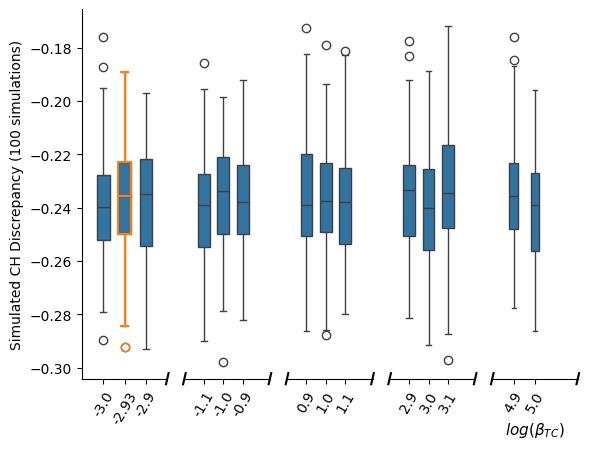

In [98]:
# betaTC
param_name = [ 'log_betaTC', 'log_betaDR', 'deltaICEV','lam1', 'log_chi']
param_list=['$log(\\lambda_1)$','$\\delta_{ICEV}$','$log(\\beta_{TC})$','$log(\\beta_{log DR})$','$log (\\chi-A)$']
print(lows_u)
print(highs_u)
plt.figure(figsize=[20, 8])

param_index = [0,1,2,3,4]

num_point = 14
iter_num = 100

i = 0 # the index of parameters, try from 0 to 4, to see the discrepancy variations over param_name[i].

MOBOLFI_index = [2,3,1,0,4]
test_theta = [ -2.93417911, -0.39818584, 0.55885794,4.26972193,  0.6904296] # MOBOLFI

# RT_data_mean = pd.read_csv("MOBOLFI_dis_rt"+param_name[i]+".csv") # RT discrepancy
RT_data_mean = pd.read_csv("MOBOLFI_dis_ch"+param_name[i]+".csv") # choice discrepancy
# print(RT_data_mean)

candidate_para0 = np.linspace(lows_u[MOBOLFI_index[i]],highs_u[MOBOLFI_index[i]], num = 5)
tmp_candidate_para_1 = candidate_para0[0:4]+0.1
tmp_candidate_para_2 = candidate_para0[1:5]-0.1
candidate_para = []
candidate_para.extend(candidate_para0.tolist())
candidate_para.extend(tmp_candidate_para_1.tolist())
candidate_para.extend(tmp_candidate_para_2.tolist())
candidate_para.append(np.round(test_theta[i],2))
candidate_para = np.sort(candidate_para).tolist()
print(candidate_para)


temp = np.zeros((iter_num*num_point,2))
# RT_data_mean = RT_data_mean.to_numpy()
print(RT_data_mean)
index_tmp =np.arange(stop = 14, step = 1).tolist()
# index_tmp.remove(8) # the index of MAP
RT_data_mean = RT_data_mean.iloc[:,index_tmp].to_numpy()

temp[:,0] = RT_data_mean.reshape((iter_num*num_point,))
temp[:,1] = candidate_para*iter_num

# temp = pd.DataFrame(temp, columns=["RT","para"])

# fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, sharex='none',sharey=True, gridspec_kw={'hspace':0.01}) #width_ratios=[1/7,3/14,1/14,3/14,13/14,1/7]
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, sharex='none',sharey=True, gridspec_kw={'hspace':0.01}) 
index_1 =  pd.DataFrame(temp, columns=["RT","para"])

index_1.drop(index_1[index_1.para>candidate_para[2]].index, inplace=True)
f1 = sns.boxplot(data=index_1, x="para", y="RT",  ax=ax1,width = 0.6)#,showfliers=False

index_1.drop(index_1[index_1.para!=candidate_para[1]].index, inplace=True)
f1 = sns.boxplot(data=index_1, x="para", y="RT",  ax=ax1,width = 0.6,linecolor="C1",fill = False) 
index_2 =   pd.DataFrame(temp, columns=["RT","para"])
index_2.drop(index_2[(index_2.para>candidate_para[5] )|( index_2.para<candidate_para[3])].index, inplace=True)

f2 = sns.boxplot(data=index_2, x="para", y="RT",  ax=ax2,width = 0.6) 

index_3 =   pd.DataFrame(temp, columns=["RT","para"])

index_3.drop(index_3[(index_3.para>candidate_para[8] )|( index_3.para<candidate_para[6])].index, inplace=True)
f3 = sns.boxplot(data= index_3, x="para", y="RT",  ax=ax3,width = 0.6)# real data


index_4 =   pd.DataFrame(temp, columns=["RT","para"])

index_4.drop(index_4[(index_4.para>candidate_para[11] )|(index_4.para<candidate_para[9])].index, inplace=True)
f4 = sns.boxplot(data= index_4, x="para", y="RT",  ax=ax4, width = 0.6)

index_5 =   pd.DataFrame(temp, columns=["RT","para"])
index_5.drop(index_5[(index_5.para<candidate_para[12] )].index, inplace=True)
f5 = sns.boxplot(data= index_5, x="para", y="RT",  ax=ax5,width = 0.4) 
# index_6 =   pd.DataFrame(temp, columns=["RT","para"])
# index_6.drop(index_6[index_6.para<candidate_para[12]].index, inplace=True)
# f6 = sns.boxplot(data=index_6, x="para", y="RT",  ax=ax6,width = 0.4) 

d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)        # top-left diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
ax2.plot((1-d, 1+d), (-d, +d), **kwargs)
kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
ax3.plot((1-d, 1+d), (-d, +d), **kwargs)
kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
ax4.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
ax4.plot((1-d, 1+d), (-d, +d), **kwargs)
kwargs.update(transform=ax5.transAxes)  # switch to the bottom axes
ax5.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
ax5.plot((1-d, 1+d), (-d, +d), **kwargs)
kwargs.update(transform=ax6.transAxes)  # switch to the bottom axes
ax6.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal

ax1.set_xlim((candidate_para[4],candidate_para[10]))
ax2.set_xlim((candidate_para[4],candidate_para[10]+0.2*2))
ax3.set_xlim((candidate_para[4],candidate_para[10]+0.2*2))
ax4.set_xlim((candidate_para[4],candidate_para[10]+0.2*2))
ax5.set_xlim((candidate_para[4],candidate_para[10]))
ax6.set_xlim((candidate_para[4],candidate_para[10]))

sns.despine(ax=ax1, right=True)
sns.despine(ax=ax2, left=True,right=True)
sns.despine(ax=ax3, left=True,right=True)
sns.despine(ax=ax4, left=True,right=True)
sns.despine(ax=ax5, left=True,right=True)
sns.despine(ax=ax6, left=True,right=True)


ax2.tick_params( axis='y',  which='both', left=False,   right=False,  labelleft=False)
ax3.tick_params( axis='y',  which='both', left=False,   right=False,  labelleft=False)
ax4.tick_params( axis='y',  which='both', left=False,   right=False,  labelleft=False)
ax5.tick_params( axis='y',  which='both', left=False,   right=False,  labelleft=False)
ax6.tick_params( axis='y',  which='both', left=False,   right=False,  labelleft=False)
ax1.tick_params( axis='x', labelsize = 10, rotation = 60)
ax2.tick_params( axis='x', labelsize = 10,rotation = 60)
ax3.tick_params( axis='x', labelsize = 10,rotation = 60)
ax4.tick_params( axis='x', labelsize = 10,rotation = 60)#
ax5.tick_params( axis='x', labelsize = 10,rotation = 60)
ax6.tick_params( axis='x', labelsize = 10,rotation = 60)








ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')


# ax1.set_ylabel("Simulated RT Discrepancy (100 simulations)",fontsize=10)   # for RT discrepancy
ax1.set_ylabel("Simulated CH Discrepancy (100 simulations)",fontsize=10)    # for CH discrepancy
plt.xlabel(param_list[MOBOLFI_index[i]],fontsize=11) # MOBOLFI


# plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_fixedallbutone_100iter_RT_MO_'+param_name[i]+'.pdf',bbox_inches='tight', pad_inches=0) # for RT discrepancy
plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_fixedallbutone_100iter_CH_MO_'+param_name[i]+'.pdf',bbox_inches='tight', pad_inches=0) # for CH discrepancy
plt.show()

MCMC convergence diagnosis

In [169]:
(len(coords_demcmc_last)-1)/chain_num

300.0

In [170]:
#Dianostics plot


chain_num=15
iter_num=10000
burn_in=6000
# All Chains
coords_demcmc_all_chains = np.zeros((chain_num, int( (len(coords_demcmc_last)-1)/chain_num), num_of_parameters+1))
coords_demcmc_all_chains_ch = np.zeros((chain_num,   int((len(coords_demcmc_last)-1)/chain_num), num_of_parameters+1))
coords_demcmc_all_chains_rt = np.zeros((chain_num,   int((len(coords_demcmc_last)-1)/chain_num), num_of_parameters+1))

index_chain = 0
for j in range(1,len(coords_demcmc_last)):
    sample_onechain = coords_demcmc_last[j,:] 
    coords_demcmc_all_chains[index_chain,(j-1)//chain_num,:] = sample_onechain
    sample_onechain_ch = coords_demcmc_last_ch[j,:] 
    coords_demcmc_all_chains[index_chain,(j-1)//chain_num,:] = sample_onechain
    sample_onechain_rt = coords_demcmc_last_rt[j,:] 
    coords_demcmc_all_chains[index_chain,(j-1)//chain_num,:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num:
        index_chain = 0
        
        
        



In [171]:
real_theta_u


[0.2120024,
 0.5799932,
 2.0627080901415162,
 1.1012555255708283,
 0.7333077884122489]

In [172]:
real_theta_u[mobolfi_llk_index[1]]

0.7333077884122489

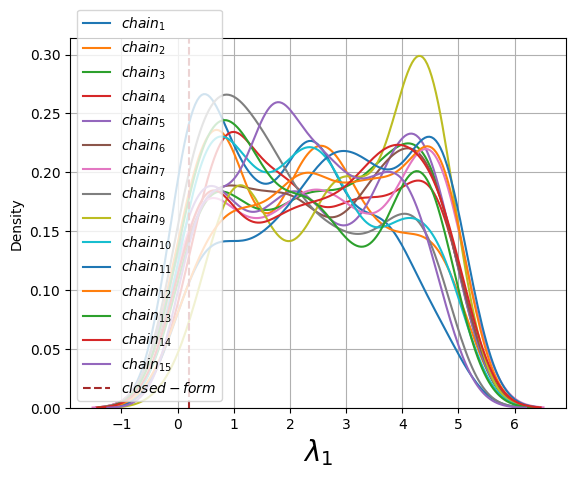

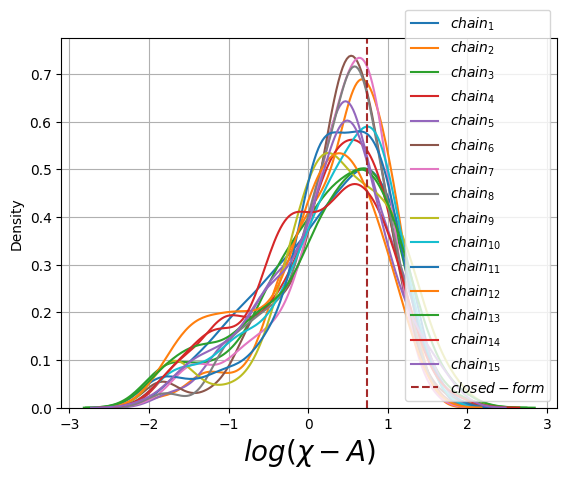

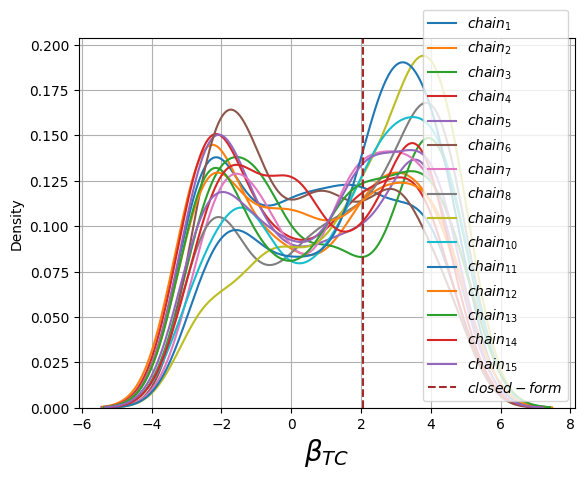

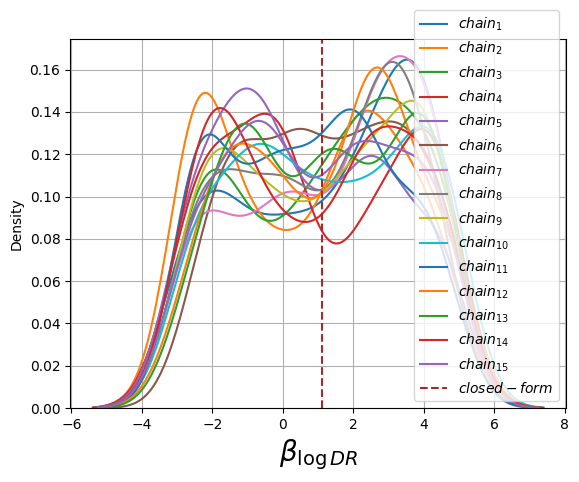

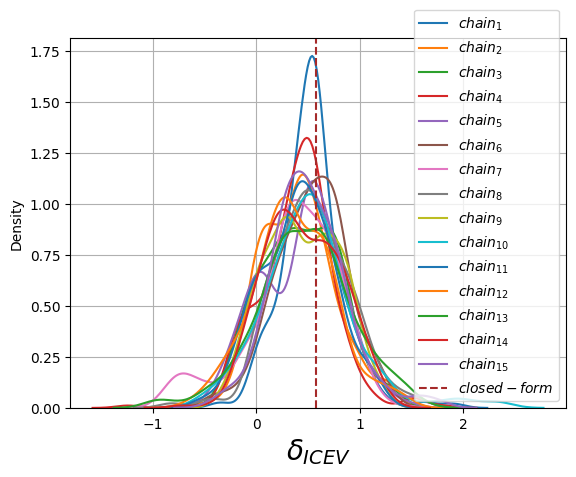

In [174]:
#Multiple chains diagnostics
import seaborn as sns

# chain_list = ['$chain_1$','$chain_2$','$chain_3$','$chain_4$','$chain_5$','$chain_6$','$chain_7$','$chain_8$','$chain_9$']
chain_list = ['$chain_1$','$chain_2$','$chain_3$','$chain_4$','$chain_5$','$chain_6$','$chain_7$','$chain_8$','$chain_9$','$chain_{10}$','$chain_{11}$',
              '$chain_{12}$','$chain_{13}$','$chain_{14}$','$chain_{15}$']

param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']

mobolfi_llk_index = [0,4,2,3,1]


for i in range(num_of_parameters):
    for j in range(chain_num):
        sns.kdeplot(coords_demcmc_all_chains[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=1)
    plt.axvline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$closed-form$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()



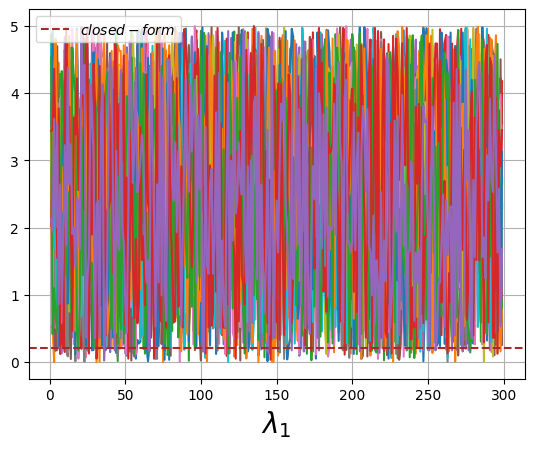

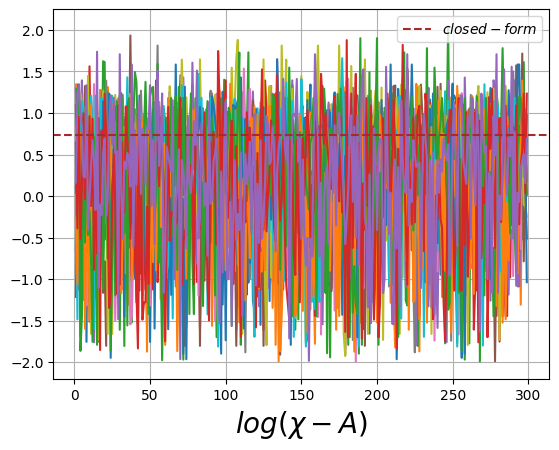

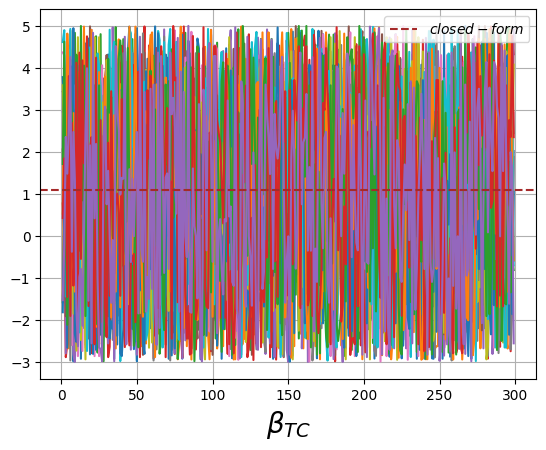

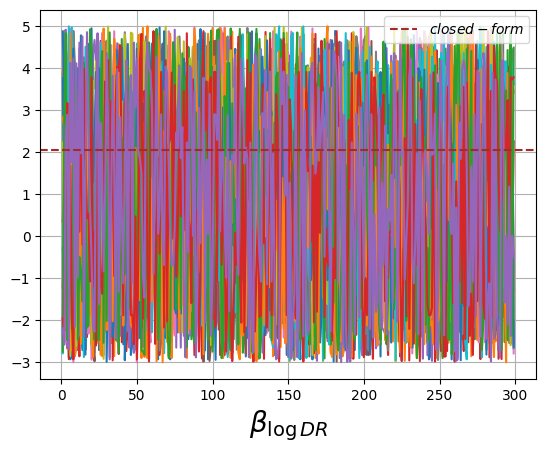

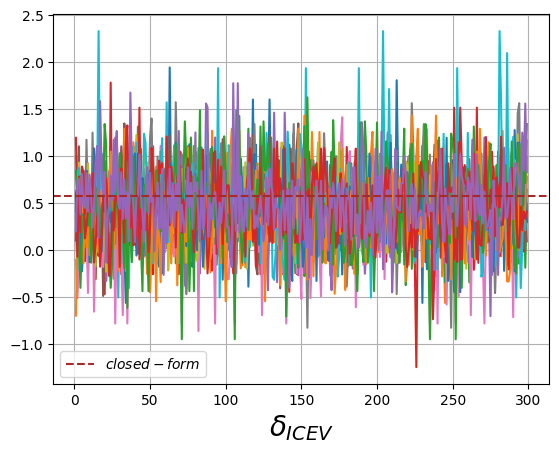

In [175]:
# Trace plots
param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']
mobolfi_llk_index = [0,4,3,2,1]
for i in range(num_of_parameters):

    for j in range(chain_num):
        plt.plot(list(range(1,coords_demcmc_all_chains[j].shape[0])),coords_demcmc_all_chains[j][:-1,mobolfi_llk_index[i]])
    # plt.plot(list(range(1,coords_demcmc_all_chains[-2].shape[0])),coords_demcmc_all_chains[-2][1:,mobolfi_llk_index[i]])
    plt.axhline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$closed-form$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    
    plt.show()




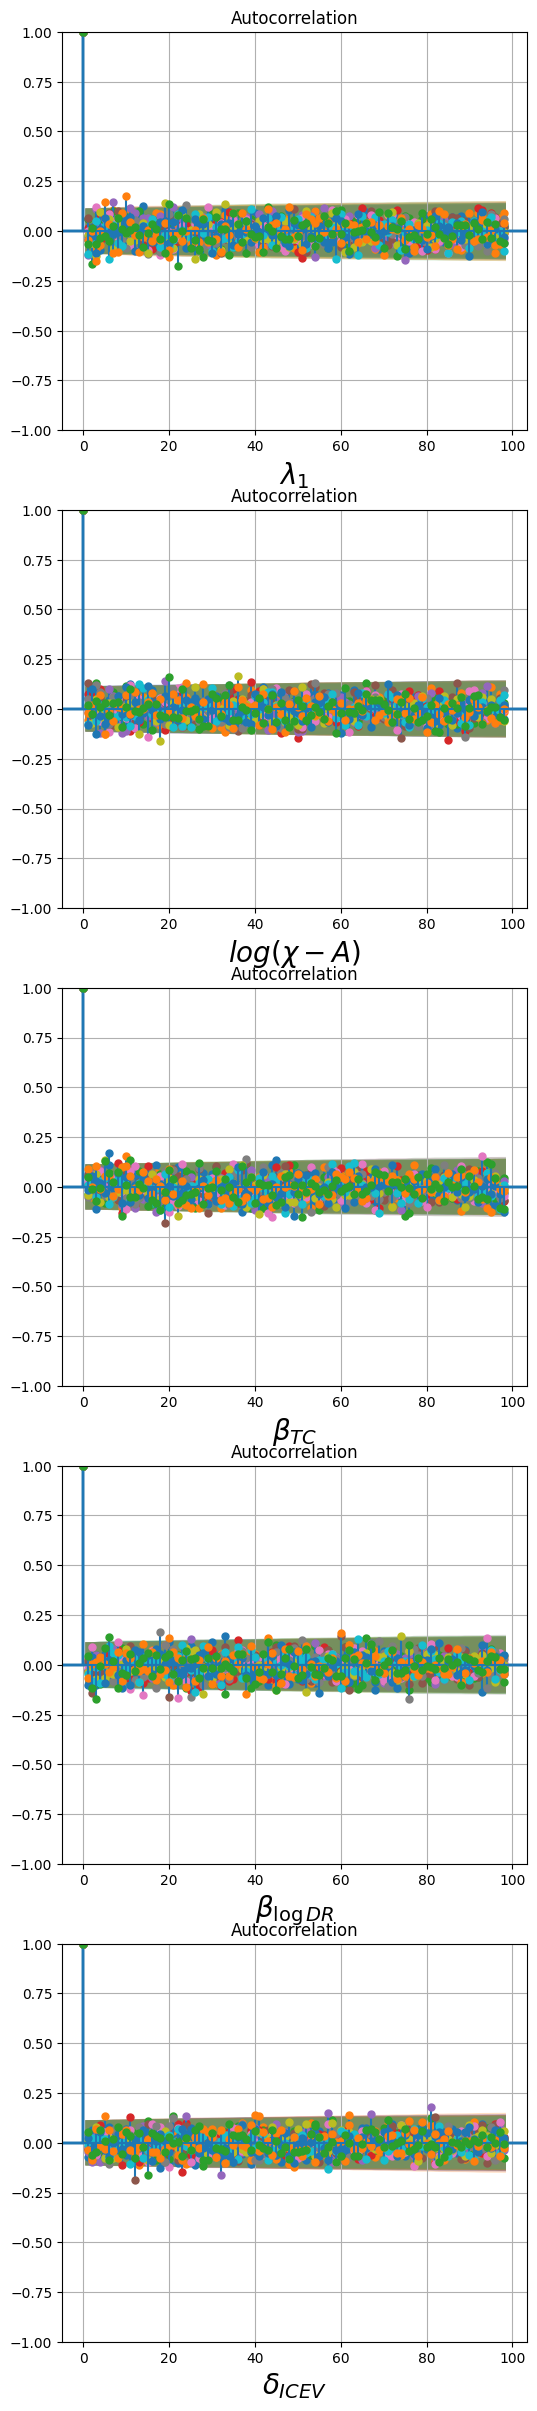

In [176]:
# ACF plots
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(num_of_parameters, 1, figsize=(6,num_of_parameters*6),sharey=True)

for i in range(num_of_parameters):
    for j in range(chain_num-2):
        plot_acf(coords_demcmc_all_chains[j][:-1,mobolfi_llk_index[i]], ax=axs[i],lags=98)
    axs[i].grid()
    axs[i].tick_params(axis='both', labelsize=fs)
    axs[i].set_xlabel(param_list[i],fontsize=font_size_text)

plt.show()